In [168]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress#, LPostBestAddress

import seaborn as sbn

from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)

import plotly.express as px

from zipfile import ZipFile
import json
import random

import os, urllib



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [169]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [170]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [171]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [172]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [173]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [174]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_local": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon_local": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_local": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon_local": {
            "house": "building",
            "locality": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if record.geocoder == "pelias":
        raw_label = record.location.raw["properties"]
        if raw_label["match_type"] == "exact":
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        return "[UNKNOWN]"
    
    

In [175]:
geocoders = {}

In [176]:
from geopy.geocoders import Nominatim
geocoders['nominatim_local'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [177]:
# geocoders['nominatim_local2'] = Nominatim(user_agent="smalsresearch", domain="172.17.0.2:8080", scheme="http", timeout=1000)
# geocoders['nominatim_local'].geocode("Chaussée de Tervueren 59, Auderghem, Bruxelles").raw

In [178]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [179]:
# geocoders['nominatim_wrapper'].geocode("Chaussée de Wavre")

In [180]:
# geocoders['lpost_bestaddress'] = LPostBestAddress(user_agent="smalsresearch", scheme="http", timeout=1000, domain="10.1.0.45:7777")
# geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="http", timeout=1000, domain="10.1.0.45:7777")

In [181]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [182]:
from geopy.geocoders import Pelias
geocoders['pelias'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [183]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [184]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [185]:
from geopy.geocoders import Photon
geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon_local'] = Photon(domain="127.0.0.1:2322", scheme="http")

In [186]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [187]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [188]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [189]:
geocoders['photon_local'].geocode("Chaussée de Tervuren 59, 1160 Auderghem")

Location(59, Chaussée de Tervuren - Tervuursesteenweg, 1160, Chaussée de Tervuren - Tervuursesteenweg, Auderghem - Oudergem, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, België / Belgique / Belgien, (50.8160028, 4.432422643201134, 0.0))

In [190]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [191]:
# dataset = "rrn_1000"
# dataset = "kbo_1000"
# dataset = "best_1000"
# dataset = "rep_1000"
dataset = "resto_1000"

In [192]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [193]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3            Rue du Hock(N), 36, 4121 Neupré, Belgique  
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
..                                                 ...  
995            Lichterweg, 3, 2030 Antwerpen, Belgique  
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique  
997             Heerweg-Noord, 72, 9052 Gent, Belgique  
998              Mechelbaan, 750, 2580 Putte, Belgique  
999           Dikkebusseweg, 126, 8900 Ieper, Belgique  

[1000 rows x 5 columns]

In [194]:
# data[data.street.duplicated()]

In [195]:
data[data.address.isnull()]

Empty DataFrame
Columns: [street, housenumber, postcode, city, address]
Index: []

In [196]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

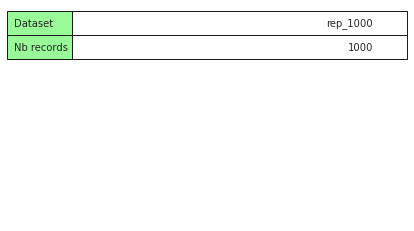

In [197]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf.savefig( bbox_inches='tight')

# Geocode

In [198]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [199]:
#no_res_timing_df.append({"address": "test", "duration": 0.5, "geocoder": "test"}, ignore_index=True)

In [200]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr, 
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [201]:
geocoded_data_r = []#gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google", "pelias"]
# coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "tomtom", "google","pelias", "bestaddress"]

# coders=["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox", "google", "lpost_bestaddress", "tomtom"]
# coders=["nominatim_wrapper"]
delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim_local":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4}
# from_file = ["nominatim_wrapper", "here", "bing", "mapbox", "tomtom", "google","pelias"] #"here", "bing", "mapbox",  "google",  "lpost_bestaddress", "tomtom"]#"here", "bing", "mapbox", "tomtom", "google",  "nominatim_wrapper","nominatim_local"]#"nominatim_wrapper","nominatim_local", "here", "bing", "mapbox", "tomtom", "trillium", "google"]#"nominatim_local", "photon_local", "here", "bing", "mapbox"]
from_file = coders
from_file = []
# from_file = ["nominatim_wrapper", "nominatim_local", "here", "bing", "mapbox"]
for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder == "bestaddress": # structured BestAddress
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)
        else: 
            g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

nominatim_wrapper


100%|██████████| 1000/1000 [01:34<00:00, 10.53it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location           geocoder  
0    (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper  
1    (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper  
2    (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper  
3    (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper  
4    (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper  
..                                                 ...                ...  
995  (Lichterweg, Antwerpen, Vlaanderen, 2030, Belg...  nominatim_wrapper  
996  (41, Grote Markt, Begijnhof Sint-Elisabeth, Ko...  nominatim_wrapper  
997  (Heerweg-Noord, Zwijnaarde, Gent, Oost-Vlaande...  nominatim_wrapper  
998  (Mechelbaan, Putte, Mechelen, Antwerpen, Vlaan...  nominatim_wrapper  
999  (Dikkebusseweg, Ieper, West-Vlaanderen, Vlaand...  nominatim_wrapper  

[1000 rows x 7 columns]

nominatim_local


100%|██████████| 1000/1000 [00:15<00:00, 64.95it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location         geocoder  
0    (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_local  
1    (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_local  
2    (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_local  
3    (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_local  
4    (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_local  
..                                                 ...              ...  
995  (Lichterweg, Antwerpen, Vlaanderen, 2030, Belg...  nominatim_local  
996                                               None  nominatim_local  
997  (Heerweg-Noord, Zwijnaarde, Gent, Oost-Vlaande...  nominatim_local  
998  (Mechelbaan, Putte, Mechelen, Antwerpen, Vlaan...  nominatim_local  
999  (Dikkebusseweg, Ieper, West-Vlaanderen, Vlaand...  nominatim_local  

[1000 rows x 7 columns]

here


100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  
0    (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...     here  
1    (Nachtegalenlaan 35, 1950 Kraainem, België, Kr...     here  
2    (Rue Tilia 12, 6511 Beaumont, Belgique, Beaumo...     here  
3    (Rue du Hock 36, 4121 Neupré, Belgique, Neupré...     here  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, België, ...     here  
..                                                 ...      ...  
995  (Lichterweg, 2030 Antwerpen, België, Antwerpen...     here  
996  (Grote Markt 41, 8500 Kortrijk, België, Kortri...     here  
997  (Heerweg-Noord 72, 9052 Gent, België, Gent, Vl...     here  
998  (Mechelbaan 750, 2580 Putte, België, Putte, Vl...     here  
999  (Dikkebusseweg 126, 8900 Ieper, België, Ieper,...     here  

[1000 rows x 7 columns]

bing


100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  
0    (Avenue de Burbure 46, Wezembeek-Oppem, Flemis...     bing  
1    (Avenue des Rossignols 35, Kraainem, Flemish R...     bing  
2    (Rue Tilia 12, Beaumont, Walloon Region 6511, ...     bing  
3    (Rue du Hock 36, Neuville-en-Condroz, Walloon ...     bing  
4    (Wuustwezelseweg 95, Wuustwezel, Flemish Regio...     bing  
..                                                 ...      ...  
995  (Lichterweg, Antwerp, Flemish Region 2000, Bel...     bing  
996  (Grote Markt 41, Kortrijk, Flemish Region 8500...     bing  
997  (Heerweg-Noord 72, Ghent, Flemish Region 9052,...     bing  
998  (Mechelbaan 750, Putte, Flemish Region 2580, B...     bing  
999  (Dikkebusseweg 126, leper, Flemish Region 8900...     bing  

[1000 rows x 7 columns]

mapbox


100%|██████████| 1000/1000 [08:20<00:00,  2.00it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  
0    (Oscar De Burburelaan - Avenue Oscar De Burbur...   mapbox  
1    (Nachtegalenlaan 35, 1950 Kraainem, Flemish Br...   mapbox  
2    (6511, Beaumont, Hainaut, Belgium, (50.276633,...   mapbox  
3    (Rue Du Hock, 4121 Neupré, Liege, Belgium, (50...   mapbox  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, Antwerp,...   mapbox  
..                                                 ...      ...  
995  (Lichterweg, 2030 Antwerpen, Antwerp, Belgium,...   mapbox  
996  (Grote Markt, Grote Markt, Kortrijk, West Flan...   mapbox  
997  (Heerweg-Noord 72, 9052 Gent, East Flanders, B...   mapbox  
998  (Mechelbaan 750, 2580 Putte, Antwerp, Belgium,...   mapbox  
999  (Dikkebusseweg 126, 8900 Ieper, West Flanders,...   mapbox  

[1000 rows x 7 columns]

tomtom


 21%|██        | 206/1000 [01:21<05:16,  2.51it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Place Saint-Denis, 65/67, 1190 Forest, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 136, in _retries_gen

RateLimiter swallowed an error after 2 retries. Called with (*('Clos des Lavandières, 5/31, 4000 Liège, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 274, in __call__
    res = self.func(*args, **kwargs)
  File "/tmp/ipyke

RateLimiter caught an error, retrying (1/2 tries). Called with (*('Rue des Faînes, 21/23, 1120 Bruxelles, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 136, in _retries_gen
    yield i  # Run the function.
  File "/home/vb

 65%|██████▌   | 653/1000 [05:11<02:16,  2.54it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Chaussée de Lille(OR), 479/2, 7501 Tournai, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 136, in _retrie

RateLimiter swallowed an error after 2 retries. Called with (*('Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, Belgique',), **{}).
Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 404

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopy/extra/rate_limiter.py", line 274, in __call__
    res = self.func(*args, **kwargs)
  File "/tmp

street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  
0    (De Burburelaan 46, 1970 Wezembeek-Oppem, (50....   tomtom  
1    (Nachtegalenlaan 35, 1950 Kraainem, (50.85665,...   tomtom  
2    (Rue de la Station 12, 6511 Beaumont, (50.2741...   tomtom  
3    (Rue du Hock 36, 4121 Neupré, (50.55351, 5.455...   tomtom  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, (51.4005...   tomtom  
..                                                 ...      ...  
995   (Lichterweg, 2000 Antwerpen, (51.24925, 4.3869))   tomtom  
996  (Grote Markt 41, 8500 Kortrijk, (50.82714, 3.2...   tomtom  
997  (Heerweg-Noord 72, 9052 Gent, (51.00594, 3.716...   tomtom  
998    (Mechelbaan 750, 2580 Putte, (51.0383, 4.5766))   tomtom  
999  (Dikkebusseweg 126, 8900 Ieper, (50.84248, 2.8...   tomtom  

[1000 rows x 7 columns]

google


100%|██████████| 1000/1000 [08:20<00:00,  2.00it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  
0    (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...   google  
1    (Nachtegalenlaan 35, 1950 Kraainem, Belgium, (...   google  
2    (Rue Tilia 12, 6511 Beaumont, Belgium, (50.273...   google  
3    (Rue du Hock 36, 4121 Neupré, Belgium, (50.553...   google  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, Belgium,...   google  
..                                                 ...      ...  
995  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...   google  
996  (Grote Markt, 8500 Kortrijk, Belgium, (50.8276...   google  
997  (Heerweg-Noord 72, 9052 Gent, Belgium, (51.005...   google  
998  (Mechelbaan 750, 2580 Putte, Belgium, (51.0382...   google  
999  (Dikkebusseweg 126, 8900 Ieper, Belgium, (50.8...   google  

[1000 rows x 7 columns]

pelias


100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                         location geocoder  
0         (Wezembeek-Oppem, (50.844132, 4.49277))   pelias  
1               (Kraainem, (50.855488, 4.469186))   pelias  
2               (Beaumont, (50.236346, 4.238044))   pelias  
3                     (Ehein, (50.54573, 5.4451))   pelias  
4        (Wuustwezelseweg 95, (51.4005, 4.62705))   pelias  
..                                            ...      ...  
995            (Antwerpen, (51.246664, 4.402453))   pelias  
996             (Kortrijk, (50.837035, 3.275675))   pelias  
997        (Heerweg-Noord 72, (51.00594, 3.7168))   pelias  
998         (Mechelbaan 750, (51.03833, 4.57662))   pelias  
999  (Dikkebusseweg 126, (50.8419357, 2.8719322))   pelias  

[1000 rows x 7 columns]

## Gather results

In [202]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
7995        Lichterweg           3     2030        Antwerpen   
7996  Grote Markt(Kor)          41     8500         Kortrijk   
7997     Heerweg-Noord          72     9052             Gent   
7998        Mechelbaan         750     2580            Putte   
7999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
7995            Lichterweg, 3, 2030 Antwerpen, Belgique   
7996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
7997             Heerweg-Noord, 72, 9052 Gent, Belgique   
7998              Mechelbaan, 750, 2580 Putte, Belgique   
7999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location           geocoder  
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper  
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper  
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper  
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper  
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper  
...                                                 ...                ...  
7995                 (Antwerpen, (51.246664, 4.402453))             pelias  
7996                  (Kortrijk, (50.837035, 3.275675))             pelias  
7997             (Heerweg-Noord 72, (51.00594, 3.7168))             pelias  
7998              (Mechelbaan 750, (51.03833, 4.57662))             pelias  
7999       (Dikkebusseweg 126, (50.8419357, 2.8719322))             pelias  

[7849 rows x 7 columns]

In [203]:
geocoded_data.geocoder.value_counts()

here                 1000
bing                 1000
mapbox               1000
google               1000
pelias                999
nominatim_wrapper     994
tomtom                993
nominatim_local       863
Name: geocoder, dtype: int64

In [204]:
# geocoded_data[geocoded_data.street=="LANGESTRAAT(OW)"]

## Duration

In [205]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [206]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


7849

In [207]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [208]:
# if len(no_res_timing) >0:
#     no_res_timing_df = pd.concat([pd.DataFrame(no_res_timing[x]).rename(columns={0:"address", 1:"duration"}).assign(geocoder=x) for x in no_res_timing])#.drop("index", axis=1)
#     #pd.DataFrame(no_res_timing).unstack().rename("duration").reset_index().rename(columns={"level_0": "geocoder"}).drop("level_1", axis=1)
#     no_res_timing_df["duration"] = no_res_timing_df["duration"].dt.total_seconds()
    
#     no_res_timing_df.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
# else: 
#     try: 
#         no_res_timing_df = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
#     except FileNotFoundError: 
#         no_res_timing_df = pd.DataFrame(columns =["address", "geocoder", "duration"] )
# no_res_timing_df

In [209]:
geocoded_data_duration = pd.concat([geocoded_data[(geocoded_data.geocoder!="trillium")].assign(with_result=True), no_res_timing.assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [210]:
geocoded_data_duration

address           geocoder  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  nominatim_wrapper   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique  nominatim_wrapper   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique  nominatim_wrapper   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique  nominatim_wrapper   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  nominatim_wrapper   
...                                                 ...                ...   
7988  Libramont,Avenue de Houffalize, 42b, 6800 Libr...    nominatim_local   
7989  Rue Prisonniers de Guerre(FLM), 22, 6141 Fonta...    nominatim_local   
7990  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique    nominatim_local   
7991      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique    nominatim_local   
7992   Bareel(DKL), 13, 9170 Sint-Gillis-Waas, Belgique             pelias   

      duration  with_result  
0     0.075832         True  
1     0.030597         True  
2     0.055077         True  
3     0.082737         True  
4     0.071004         True  
...        ...          ...  
7988  0.028753        False  
7989  0.003306        False  
7990  0.003224        False  
7991  0.027425        False  
7992  0.016907        False  

[7993 rows x 4 columns]

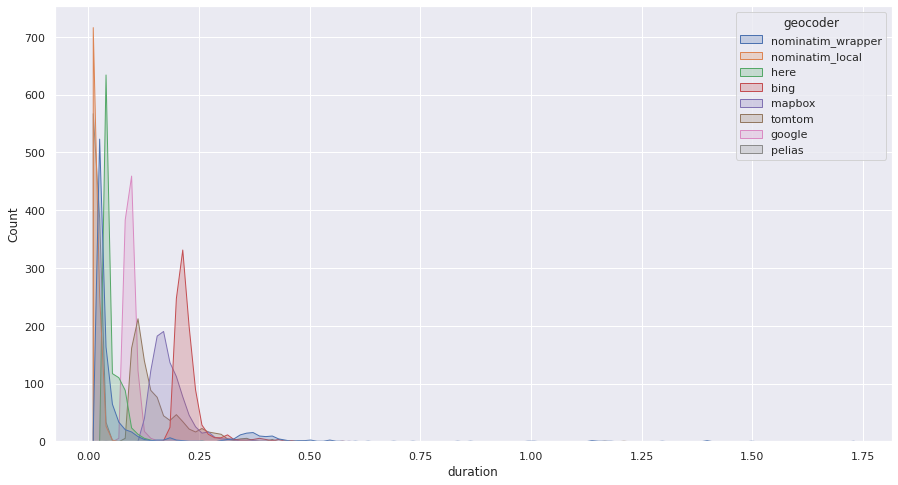

In [211]:
plt.figure(figsize=(15,8))
sbn.histplot(geocoded_data_duration, x="duration", hue="geocoder", element="poly", )
pdf.savefig(bbox_inches='tight')

In [212]:
# pd.concat([geocoded_data, no_res_timing_df]).groupby("geocoder").duration.mean()

In [213]:
# geocoded_data.groupby("geocoder").duration.mean()

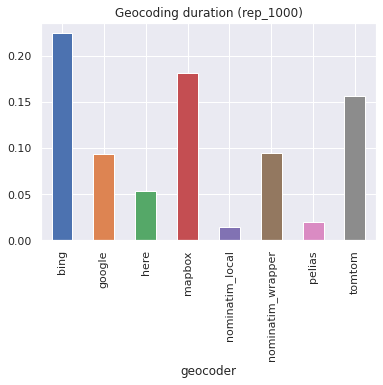

In [214]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, title=f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

<AxesSubplot:title={'center':'Geocoding duration (rep_1000)'}, xlabel='geocoder'>

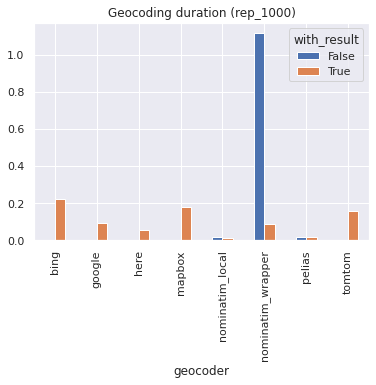

In [215]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})")

In [216]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

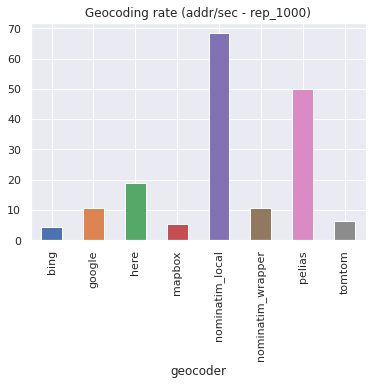

In [217]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, title=f"Geocoding rate (addr/sec - {dataset})")
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

In [218]:
geocoded_data_duration[geocoded_data_duration[["address", "geocoder"]].duplicated(keep=False)]

Empty DataFrame
Columns: [address, geocoder, duration, with_result]
Index: []

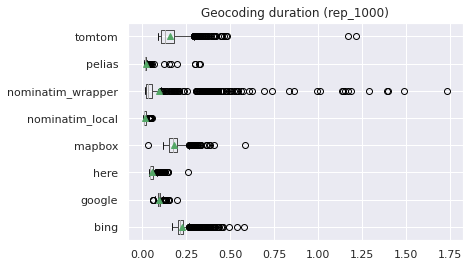

In [219]:
d = geocoded_data_duration.drop_duplicates(subset=["address",  "geocoder"]).pivot(index="address", columns="geocoder", values="duration")
ax = d.boxplot(showmeans=True, vert=False)
plt.title(f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed_boxplot.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')
# ax.set_yscale("log")

In [220]:
geocoded_data[geocoded_data.geocoder!="trillium"][["geocoder", "duration"]].groupby("geocoder").describe()


duration                                                    \
                     count      mean       std       min       25%       50%   
geocoder                                                                       
bing                1000.0  0.224475  0.041154  0.167804  0.203892  0.214211   
google              1000.0  0.093860  0.011298  0.061345  0.086171  0.092116   
here                1000.0  0.053327  0.018885  0.039832  0.042625  0.044208   
mapbox              1000.0  0.181345  0.041573  0.032654  0.154250  0.172905   
nominatim_local      863.0  0.014089  0.007174  0.007712  0.009604  0.011003   
nominatim_wrapper    994.0  0.088457  0.162233  0.015324  0.022163  0.029140   
pelias               999.0  0.020078  0.021293  0.011467  0.015371  0.016888   
tomtom               993.0  0.156546  0.080546  0.088143  0.108403  0.129512   

                                       
                        75%       max  
geocoder                               
bing               0.228867  0.579103  
google             0.099619  0.196421  
here               0.059545  0.258693  
mapbox             0.199222  0.586587  
nominatim_local    0.015758  0.054203  
nominatim_wrapper  0.053415  1.736081  
pelias             0.019224  0.328072  
tomtom             0.181879  1.214081

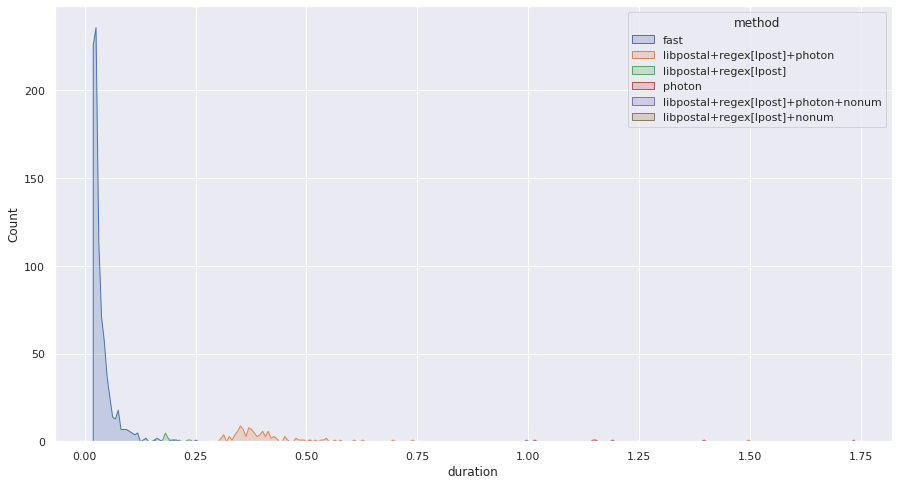

In [221]:
nw = geocoded_data[geocoded_data.geocoder=="nominatim_wrapper"]
nw = nw.assign(method=nw.location.apply(lambda x:x.raw["metadata"]["method"]))
plt.figure(figsize=(15,8))
g =sbn.histplot(nw, x="duration", hue="method", element="poly")
# g.set_yscale('log')

# nw

<AxesSubplot:>

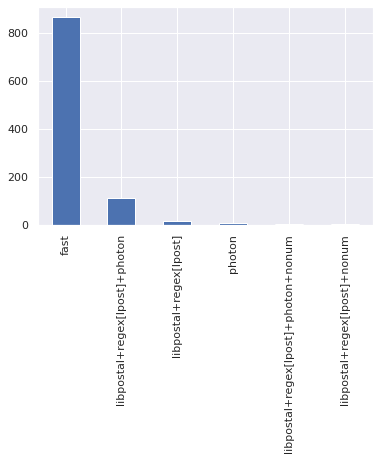

In [222]:
nw.method.value_counts().plot.bar()

<AxesSubplot:xlabel='method'>

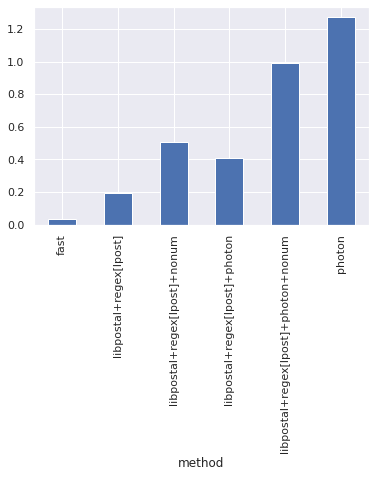

In [223]:
# sbn.barplot(nw.groupby("method").address.count().reset_index(), x="method", y="address")
nw.groupby("method").duration.mean().plot.bar()

## Extract precision

In [224]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [225]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

geocoder  precision                   
mapbox    [UNKNOWN]                       32
bing      [UNKNOWN - RoadIntersection]     1
dtype: int64

In [226]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

In [227]:
# geocoded_data[geocoded_data.precision== "[UNKNOWN - APPROXIMATE]"].iloc[-1].location.raw

In [228]:
# geocoded_data[geocoded_data.precision== "[UNKNOWN - APPROXIMATE]"]

In [229]:
# geocoded_data.loc[599].location.raw#["entityType"]

In [230]:
# geocoders["mapbox"].geocode("2627 Schelle").raw

In [231]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [232]:
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
7995        Lichterweg           3     2030        Antwerpen   
7996  Grote Markt(Kor)          41     8500         Kortrijk   
7997     Heerweg-Noord          72     9052             Gent   
7998        Mechelbaan         750     2580            Putte   
7999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
7995            Lichterweg, 3, 2030 Antwerpen, Belgique   
7996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
7997             Heerweg-Noord, 72, 9052 Gent, Belgique   
7998              Mechelbaan, 750, 2580 Putte, Belgique   
7999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
7995                 (Antwerpen, (51.246664, 4.402453))             pelias   
7996                  (Kortrijk, (50.837035, 3.275675))             pelias   
7997             (Heerweg-Noord 72, (51.00594, 3.7168))             pelias   
7998              (Mechelbaan 750, (51.03833, 4.57662))             pelias   
7999       (Dikkebusseweg 126, (50.8419357, 2.8719322))             pelias   

      duration precision                                 point  
0     0.075832    street          POINT (4.4804289 50.8526612)  
1     0.030597  building  POINT (4.471919714285715 50.8566551)  
2     0.055077    street          POINT (4.3009542 50.2705618)  
3     0.082737  building  POINT (5.455647599832213 50.5535129)  
4     0.071004  building  POINT (4.627042066389356 51.4004573)  
...        ...       ...                                   ...  
7995  0.018700      city            POINT (4.402453 51.246664)  
7996  0.014896      city            POINT (3.275675 50.837035)  
7997  0.015381  building               POINT (3.7168 51.00594)  
7998  0.015275  building              POINT (4.57662 51.03833)  
7999  0.019511    street          POINT (2.8719322 50.8419357)  

[7849 rows x 10 columns]

In [233]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
7995        Lichterweg           3     2030        Antwerpen   
7996  Grote Markt(Kor)          41     8500         Kortrijk   
7997     Heerweg-Noord          72     9052             Gent   
7998        Mechelbaan         750     2580            Putte   
7999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
7995            Lichterweg, 3, 2030 Antwerpen, Belgique   
7996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
7997             Heerweg-Noord, 72, 9052 Gent, Belgique   
7998              Mechelbaan, 750, 2580 Putte, Belgique   
7999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
7995                 (Antwerpen, (51.246664, 4.402453))             pelias   
7996                  (Kortrijk, (50.837035, 3.275675))             pelias   
7997             (Heerweg-Noord 72, (51.00594, 3.7168))             pelias   
7998              (Mechelbaan 750, (51.03833, 4.57662))             pelias   
7999       (Dikkebusseweg 126, (50.8419357, 2.8719322))             pelias   

      duration precision                           point  
0     0.075832    street  POINT (498759.064 6595272.461)  
1     0.030597  building  POINT (497811.825 6595976.732)  
2     0.055077    street  POINT (478780.031 6493264.898)  
3     0.082737  building  POINT (607319.913 6542692.124)  
4     0.071004  building  POINT (515079.967 6692438.032)  
...        ...       ...                             ...  
7995  0.018700      city  POINT (490078.826 6665042.258)  
7996  0.014896      city  POINT (364646.473 6592517.569)  
7997  0.015381  building  POINT (413752.283 6622344.507)  
7998  0.015275  building  POINT (509467.008 6628076.659)  
7999  0.019511    street  POINT (319702.030 6593381.461)  

[7849 rows x 10 columns]

In [234]:
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
7995        Lichterweg           3     2030        Antwerpen   
7996  Grote Markt(Kor)          41     8500         Kortrijk   
7997     Heerweg-Noord          72     9052             Gent   
7998        Mechelbaan         750     2580            Putte   
7999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
7995            Lichterweg, 3, 2030 Antwerpen, Belgique   
7996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
7997             Heerweg-Noord, 72, 9052 Gent, Belgique   
7998              Mechelbaan, 750, 2580 Putte, Belgique   
7999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
7995                 (Antwerpen, (51.246664, 4.402453))             pelias   
7996                  (Kortrijk, (50.837035, 3.275675))             pelias   
7997             (Heerweg-Noord 72, (51.00594, 3.7168))             pelias   
7998              (Mechelbaan 750, (51.03833, 4.57662))             pelias   
7999       (Dikkebusseweg 126, (50.8419357, 2.8719322))             pelias   

      duration precision                           point  
0     0.075832    street  POINT (498759.064 6595272.461)  
1     0.030597  building  POINT (497811.825 6595976.732)  
2     0.055077    street  POINT (478780.031 6493264.898)  
3     0.082737  building  POINT (607319.913 6542692.124)  
4     0.071004  building  POINT (515079.967 6692438.032)  
...        ...       ...                             ...  
7995  0.018700      city  POINT (490078.826 6665042.258)  
7996  0.014896      city  POINT (364646.473 6592517.569)  
7997  0.015381  building  POINT (413752.283 6622344.507)  
7998  0.015275  building  POINT (509467.008 6628076.659)  
7999  0.019511    street  POINT (319702.030 6593381.461)  

[7849 rows x 10 columns]

In [235]:
# geocoded_data = geocoded_data.append(trillium[["address", "geocoder", "precision"]])

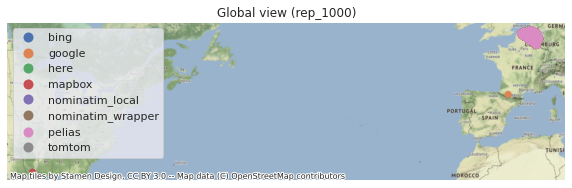

In [236]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data[geocoded_data.geocoder != "trillium"].plot("geocoder", legend=True, figsize=(10,15), cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf.savefig( bbox_inches='tight')
# plt.show()
# plt.close()


In [237]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [238]:
# belgium_boundaries

In [239]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.to_crs(crs).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).plot(ax=ax, color="red")
# plt.ylim([-10000000, 12000000])
# plt.axis("off")

In [240]:
# ax = gpd.GeoSeries({"geometry": belgium_boundaries}).plot()
# gpd.GeoSeries({"geometry": shapely.geometry.Point(0,0)}).set_crs("EPSG:31370").to_crs(crs).plot(ax=ax, color="red")
# plt.axis("off")

In [241]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     7845
False       4
Name: is_in_belgium, dtype: int64

In [242]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder           is_in_belgium
bing               True             1000
google             True              999
                   False               1
here               True             1000
mapbox             True              997
                   False               3
nominatim_local    True              863
nominatim_wrapper  True              994
pelias             True              999
tomtom             True              993
Name: is_in_belgium, dtype: int64

In [243]:
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
7995        Lichterweg           3     2030        Antwerpen   
7996  Grote Markt(Kor)          41     8500         Kortrijk   
7997     Heerweg-Noord          72     9052             Gent   
7998        Mechelbaan         750     2580            Putte   
7999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
7995            Lichterweg, 3, 2030 Antwerpen, Belgique   
7996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
7997             Heerweg-Noord, 72, 9052 Gent, Belgique   
7998              Mechelbaan, 750, 2580 Putte, Belgique   
7999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
7995                 (Antwerpen, (51.246664, 4.402453))             pelias   
7996                  (Kortrijk, (50.837035, 3.275675))             pelias   
7997             (Heerweg-Noord 72, (51.00594, 3.7168))             pelias   
7998              (Mechelbaan 750, (51.03833, 4.57662))             pelias   
7999       (Dikkebusseweg 126, (50.8419357, 2.8719322))             pelias   

      duration precision                           point  is_in_belgium  
0     0.075832    street  POINT (498759.064 6595272.461)           True  
1     0.030597  building  POINT (497811.825 6595976.732)           True  
2     0.055077    street  POINT (478780.031 6493264.898)           True  
3     0.082737  building  POINT (607319.913 6542692.124)           True  
4     0.071004  building  POINT (515079.967 6692438.032)           True  
...        ...       ...                             ...            ...  
7995  0.018700      city  POINT (490078.826 6665042.258)           True  
7996  0.014896      city  POINT (364646.473 6592517.569)           True  
7997  0.015381  building  POINT (413752.283 6622344.507)           True  
7998  0.015275  building  POINT (509467.008 6628076.659)           True  
7999  0.019511    street  POINT (319702.030 6593381.461)           True  

[7849 rows x 11 columns]

In [244]:
geocoded_data[~geocoded_data.is_in_belgium & (geocoded_data.geocoder!= "trillium") ]

street housenumber postcode             city  \
4254           Rue des Rivaux(L.L)           2     7100      La Louvière   
4625             Rue de Baume(L.L)         377     7100      La Louvière   
4983  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
6878   Rue de la Croix-Rouge, Bos.          65     5032         Gembloux   

                                                address  \
4254  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
4625  Rue de Baume(L.L), 377, 7100 La Louvière, Belg...   
4983  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
6878  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   

                                               location geocoder  duration  \
4254  (Louisiana, United States, (30.9374993015932, ...   mapbox  0.166540   
4625  (Louisiana, United States, (30.9374993015932, ...   mapbox  0.224418   
4983  (Louisiana, United States, (30.9374993015932, ...   mapbox  0.176307   
6878  (Hautes-Pyrénées, France, (43.0193924, 0.14949...   google  0.114495   

      precision                              point  is_in_belgium  
4254  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False  
4625  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False  
4983  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False  
6878       city      POINT (16642.130 5314924.034)          False

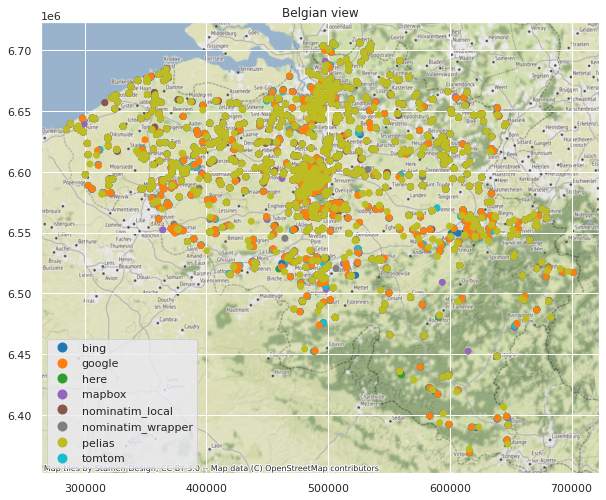

In [245]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=(10,15))
plt.title("Belgian view")
add_basemap(ax)
# img_name=f"{fig_path}/belgium_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, width=240)
pdf.savefig(bbox_inches='tight')
# plt.show()
# plt.close()


## Compute (distance to) median

In [246]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [247]:
median_geocoders = ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



address  \
0               't Vlietje, 4, 2800 Mechelen, Belgique   
1        Aalstersesteenweg, 362, 9400 Ninove, Belgique   
2         Aaltersesteenweg, 122, 9800 Deinze, Belgique   
3        Aarschotsesteenweg, 22, 3012 Leuven, Belgique   
4    Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique   
..                                                 ...   
995  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
996  de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique   
997  de Smet de Naeyerlaan, 526, 1020 Brussel, Belg...   
998   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   
999           rue du Chenia, 15, 7170 Manage, Belgique   

                       median_point  nb_points  
0    POINT (499196.315 6626069.331)          6  
1    POINT (449065.119 6596429.049)          5  
2    POINT (389868.103 6620321.889)          6  
3    POINT (524091.923 6601928.128)          6  
4    POINT (527891.497 6611051.200)          5  
..                              ...        ...  
995  POINT (498587.754 6595071.625)          5  
996  POINT (480158.345 6604332.636)          5  
997  POINT (483041.653 6600914.669)          5  
998  POINT (478803.603 6592983.817)          6  
999  POINT (472189.450 6534709.857)          3  

[1000 rows x 3 columns]

<AxesSubplot:ylabel='nb_points'>

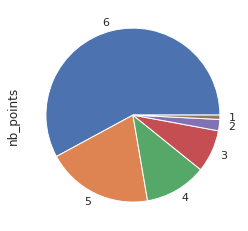

In [248]:
median_points.nb_points.value_counts().plot.pie()

In [249]:
median_points = median_points[median_points.nb_points >= 3]
median_points.shape

(971, 3)

In [250]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [251]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

street housenumber postcode                city  \
3908            Rue Joseph Wauters         3 B     4500                 Huy   
7439   Boulevard Maurice Lemonnier         197     1000           Bruxelles   
4460           Chaussée de Louvain         435     1380               Lasne   
4468                 Avenue Louise         323     1050             IXELLES   
4489                    Staatsbaan          25     9991            Maldegem   
...                            ...         ...      ...                 ...   
7595      Avenue Reine Astrid(W-B)          16     1440   Braine-le-Château   
7617                     Zandvoort          10     2030           Antwerpen   
7770  Rue Isidore-Derèse,Mornimont         155     5190  Jemeppe-sur-Sambre   
7789              Rue de Lassus(H)          46     7712            Mouscron   
7844                    Lichterweg           3     2030           Antwerpen   

                                                address  \
3908        Rue Joseph Wauters, 3 B, 4500 Huy, Belgique   
7439  Boulevard Maurice Lemonnier, 197, 1000 Bruxell...   
4460     Chaussée de Louvain, 435, 1380 Lasne, Belgique   
4468         Avenue Louise, 323, 1050 IXELLES, Belgique   
4489            Staatsbaan, 25, 9991 Maldegem, Belgique   
...                                                 ...   
7595  Avenue Reine Astrid(W-B), 16, 1440 Braine-le-C...   
7617            Zandvoort, 10, 2030 Antwerpen, Belgique   
7770  Rue Isidore-Derèse,Mornimont, 155, 5190 Jemepp...   
7789      Rue de Lassus(H), 46, 7712 Mouscron, Belgique   
7844            Lichterweg, 3, 2030 Antwerpen, Belgique   

                                               location geocoder  duration  \
3908  (Rue Joseph Wauters 3, 4500 Huy, Liege, Belgiu...   mapbox  0.172404   
7439  (Boulevard Maurice Lemonnier 197, (50.84102, 4...   pelias  0.031167   
4460  (Chaussée De Louvain 435, 1380 Lasne, Walloon ...   mapbox  0.170983   
4468  (Avenue Louise - Louizalaan 323, 1050 Brussels...   mapbox  0.160525   
4489  (Staatsbaan 25, 9991 Maldegem, East Flanders, ...   mapbox  0.150703   
...                                                 ...      ...       ...   
7595         (Braine-le-Château, (50.670147, 4.279012))   pelias  0.015900   
7617                (Zandvoort 10, (51.11259, 4.92135))   pelias  0.017138   
7770                 (Saint-Martin, (50.5012, 4.64782))   pelias  0.023131   
7789                   (Mouscron, (50.74261, 3.229175))   pelias  0.014332   
7844                 (Antwerpen, (51.246664, 4.402453))   pelias  0.018700   

     precision                           point  is_in_belgium  \
3908  building  POINT (580956.385 6537339.003)           True   
7439  building  POINT (483316.946 6593220.035)           True   
4460  building  POINT (493463.384 6569471.711)           True   
4468  building  POINT (486251.217 6589977.382)           True   
4489  building  POINT (387377.022 6657702.013)           True   
...        ...                             ...            ...   
7595      city  POINT (476337.437 6563152.654)           True   
7617  building  POINT (547842.176 6641233.807)           True   
7770      city  POINT (517392.956 6533531.581)           True   
7789      city  POINT (359470.117 6575890.082)           True   
7844      city  POINT (490078.826 6665042.258)           True   

                        median_point  nb_points  dist_to_median  
3908  POINT (580956.385 6537339.003)        5.0             0.0  
7439  POINT (483316.946 6593220.035)        6.0             0.0  
4460  POINT (493463.384 6569471.711)        5.0             0.0  
4468  POINT (486251.217 6589977.382)        5.0             0.0  
4489  POINT (387377.022 6657702.013)        5.0             0.0  
...                              ...        ...             ...  
7595                            None        NaN             NaN  
7617                            None        NaN             NaN  
7770                            None        NaN           

In [252]:
geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

street housenumber postcode       city  \
6123          Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
3130          Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
5128          Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
2130          Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
7123          Allée J.F. Kennedy(Cha)           8     5650   Walcourt   
...                               ...         ...      ...        ...   
7270  Zoning de Jumet,avenue Centrale          33     6040  Charleroi   
2277  Zoning de Jumet,avenue Centrale          33     6040  Charleroi   
6270  Zoning de Jumet,avenue Centrale          33     6040  Charleroi   
4277  Zoning de Jumet,avenue Centrale          33     6040  Charleroi   
5274  Zoning de Jumet,avenue Centrale          33     6040  Charleroi   

                                                address  \
6123  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
3130  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
5128  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
2130  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
7123  Allée J.F. Kennedy(Cha), 8, 5650 Walcourt, Bel...   
...                                                 ...   
7270  Zoning de Jumet,avenue Centrale, 33, 6040 Char...   
2277  Zoning de Jumet,avenue Centrale, 33, 6040 Char...   
6270  Zoning de Jumet,avenue Centrale, 33, 6040 Char...   
4277  Zoning de Jumet,avenue Centrale, 33, 6040 Char...   
5274  Zoning de Jumet,avenue Centrale, 33, 6040 Char...   

                                               location geocoder  duration  \
6123  (Allée J. F. Kennedy, 5650 Walcourt, Belgium, ...   google  0.103321   
3130  (Walcourt, Walloon Region 5650, Belgium, (50.2...     bing  0.226654   
5128  (Allée John Fitzgerald Kennedy 8, 5650 Walcour...   tomtom  0.182538   
2130  (Allée John F. Kennedy 7, 5650 Walcourt, Belgi...     here  0.068985   
7123                  (Walcourt, (50.254853, 4.436336))   pelias  0.023468   
...                                                 ...      ...       ...   
7270                 (Charleroi, (50.412742, 4.447697))   pelias  0.029983   
2277  (Avenue Centrale 33, 6001 Charleroi, Belgique,...     here  0.081721   
6270  (Avenue Centrale, 6001 Charleroi, Belgium, (50...   google  0.104285   
4277  (Avenue Centrale 33, 6001 Charleroi, Hainaut, ...   mapbox  0.194968   
5274  (Avenue Centrale-Zoning de Jumet, 6040 Charler...   tomtom  0.322915   

     precision                           point  is_in_belgium median_point  \
6123    street  POINT (496210.593 6492846.060)           True         None   
3130      city  POINT (493333.499 6489985.378)           True         None   
5128  building  POINT (496296.799 6492797.837)           True         None   
2130  building  POINT (496219.810 6492823.768)           True         None   
7123      city  POINT (493850.665 6490529.434)           True         None   
...        ...                             ...            ...          ...   
7270      city  POINT (495115.365 6518064.705)           True         None   
2277  building  POINT (493848.883 6508348.750)           True         None   
6270    street  POINT (493818.760 6508240.328)           True         None   
4277  building  POINT (493847.436 6508348.750)           True         None   
5274    street  POINT (496156.536 6524654.410)           True         None   

      nb_points  dist_to_median  
6123        NaN             NaN  
3130        NaN             NaN  
5128        NaN             NaN  
2130        NaN             NaN  
7123        NaN             NaN  
...         ...             ...  
7270        NaN             NaN  
2277        NaN             NaN  
6270        NaN             NaN  
4277        NaN             NaN  
5274        NaN             NaN  

[214 rows x 14 columns]

In [253]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [254]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)& (geocoded_data.geocoder != "trillium")]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=(10,12)
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

street housenumber postcode      city  \
7     Torhoutsesteenweg          66     8210  Zedelgem   
1001  Torhoutsesteenweg          66     8210  Zedelgem   
1864  Torhoutsesteenweg          66     8210  Zedelgem   
2864  Torhoutsesteenweg          66     8210  Zedelgem   
3864  Torhoutsesteenweg          66     8210  Zedelgem   
4864  Torhoutsesteenweg          66     8210  Zedelgem   
5857  Torhoutsesteenweg          66     8210  Zedelgem   
6857  Torhoutsesteenweg          66     8210  Zedelgem   

                                             address  \
7     Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
1001  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
1864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
2864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
3864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
4864  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
5857  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   
6857  Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique   

                                               location           geocoder  \
7     (Fleur de Lys, 66, Torhoutsesteenweg, Zuidwege...  nominatim_wrapper   
1001  (Fleur de Lys, 66, Torhoutsesteenweg, Zuidwege...    nominatim_local   
1864  (Torhoutsesteenweg 66, 8210 Zedelgem, België, ...               here   
2864  (Torhoutsesteenweg 66, Zedelgem, Flemish Regio...               bing   
3864  (Torhoutsesteenweg 66, 8210 Zedelgem, West Fla...             mapbox   
4864  (Torhoutsesteenweg 66, 8210 Zedelgem, (51.1381...             tomtom   
5857  (Torhoutsesteenweg 66, 8210 Zedelgem, Belgium,...             google   
6857       (Torhoutsesteenweg 66A, (51.13771, 3.15965))             pelias   

      duration precision                           point  is_in_belgium  \
7     0.031591  building  POINT (351696.072 6645769.163)           True   
1001  0.014430  building  POINT (351696.072 6645769.163)           True   
1864  0.048595  building  POINT (351695.007 6645770.884)           True   
2864  0.206868  building  POINT (351695.018 6645769.110)           True   
3864  0.267842  building  POINT (351695.675 6645770.174)           True   
4864  0.105084  building  POINT (351695.007 6645769.110)           True   
5857  0.119896  building  POINT (351695.207 6645761.339)           True   
6857  0.024045  building  POINT (351730.629 6645689.273)           True   

                        median_point  nb_points  dist_to_median  
7     POINT (351695.113 6645769.137)        6.0        0.959671  
1001  POINT (351695.113 6645769.137)        6.0        0.959671  
1864  POINT (351695.113 6645769.137)        6.0        1.750757  
2864  POINT (351695.113 6645769.137)        6.0        0.098293  
3864  POINT (351695.113 6645769.137)        6.0        1.180358  
4864  POINT (351695.113 6645769.137)        6.0        0.109051  
5857  POINT (351695.113 6645769.137)        6.0        7.798058  
6857  POINT (351695.113 6645769.137)        6.0       87.405243

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 18).

/home/vb/anaconda3/envs/gis/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).



Default basemap doesn't work...


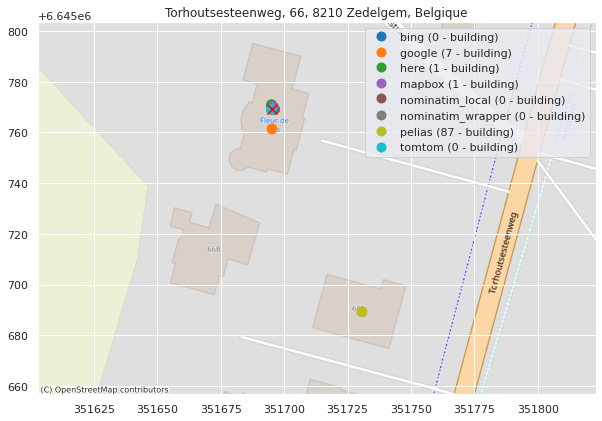

<AxesSubplot:title={'center':'Torhoutsesteenweg, 66, 8210 Zedelgem, Belgique'}>

In [255]:
plot_address(geocoded_data, geocoded_data.iloc[7].address)

street housenumber postcode             city  \
978   Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
1847  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
2840  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
3840  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
4840  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
5833  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
6833  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
7832  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   

                                                address  \
978   Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
1847  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
2840  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
3840  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
4840  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
5833  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
6833  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
7832  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   

                                               location           geocoder  \
978   (28, Rue de la Giloterie, Le Roux, Fosses-la-V...  nominatim_wrapper   
1847  (28, Rue de la Giloterie, Le Roux, Fosses-la-V...    nominatim_local   
2840  (Rue de la Giloterie 28, 5070 Fosses-la-Ville,...               here   
3840  (Rue de Vitrival 28, Fosse, Walloon Region 507...               bing   
4840  (Louisiana, United States, (30.9374993015932, ...             mapbox   
5833  (Rue de la Giloterie 28, 5070 Fosses-la-Ville,...             tomtom   
6833  (Rue de la Giloterie 28, 5070 Fosses-la-Ville,...             google   
7832           (Fosses-la-Ville, (50.390528, 4.655275))             pelias   

      duration  precision                              point  is_in_belgium  \
978   0.027525   building     POINT (516580.147 6514999.802)           True   
1847  0.012750   building     POINT (516580.147 6514999.802)           True   
2840  0.043495   building     POINT (516581.437 6514995.681)           True   
3840  0.241586   building     POINT (522579.375 6514989.412)           True   
4840  0.176307  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
5833  0.275142   building     POINT (516581.437 6514995.681)           True   
6833  0.103786   building     POINT (516571.830 6515028.964)           True   
7832  0.021399       city     POINT (518222.843 6514185.126)           True   

                        median_point  nb_points  dist_to_median  
978   POINT (516581.437 6514995.681)        5.0    4.318271e+00  
1847  POINT (516581.437 6514995.681)        5.0    4.318271e+00  
2840  POINT (516581.437 6514995.681)        5.0    0.000000e+00  
3840  POINT (516581.437 6514995.681)        5.0    5.997942e+03  
4840  POINT (516581.437 6514995.681)        5.0    1.117239e+07  
5833  POINT (516581.437 6514995.681)        5.0    0.000000e+00  
6833  POINT (516581.437 6514995.681)        5.0    3.464173e+01  
7832  POINT (516581.437 6514995.681)        5.0    1.830632e+03

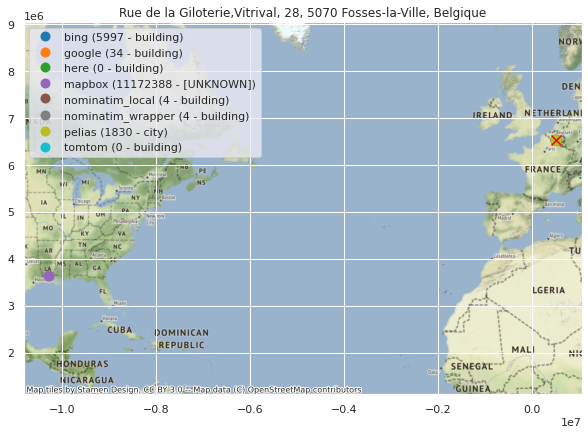

street housenumber postcode         city  \
253   Rue des Rivaux(L.L)           2     7100  La Louvière   
1220  Rue des Rivaux(L.L)           2     7100  La Louvière   
2111  Rue des Rivaux(L.L)           2     7100  La Louvière   
3111  Rue des Rivaux(L.L)           2     7100  La Louvière   
4111  Rue des Rivaux(L.L)           2     7100  La Louvière   
5109  Rue des Rivaux(L.L)           2     7100  La Louvière   
6104  Rue des Rivaux(L.L)           2     7100  La Louvière   
7104  Rue des Rivaux(L.L)           2     7100  La Louvière   

                                                address  \
253   Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
1220  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
2111  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
3111  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
4111  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
5109  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
6104  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
7104  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   

                                               location           geocoder  \
253   (NLMK Belgium Holdings Sa, 2, Rue des Rivaux, ...  nominatim_wrapper   
1220  (NLMK Belgium Holdings Sa, 2, Rue des Rivaux, ...    nominatim_local   
2111  (Rue des Rivaux 2, 7100 La Louvière, Belgique,...               here   
3111  (Rue des Rivaux, La Louvière, Walloon Region 7...               bing   
4111  (Louisiana, United States, (30.9374993015932, ...             mapbox   
5109  (Rue des Longues Haies 2, 7100 La Louvière, (5...             tomtom   
6104  (Rue des Rivaux, 7100 La Louvière, Belgium, (5...             google   
7104               (La Louvière, (50.474034, 4.195875))             pelias   

      duration  precision                              point  is_in_belgium  \
253   0.039125   building     POINT (465296.142 6530253.790)           True   
1220  0.030174   building     POINT (465296.142 6530253.790)           True   
2111  0.086683   building     POINT (465321.037 6530203.493)           True   
3111  0.492571     street     POINT (465466.726 6530185.840)           True   
4111  0.166540  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
5109  0.455055   building     POINT (467264.676 6526885.488)           True   
6104  0.108348     street     POINT (464746.095 6530015.624)           True   
7104  0.015708       city     POINT (467082.668 6528778.530)           True   

                        median_point  nb_points  dist_to_median  
253   POINT (465321.037 6530203.493)        3.0    5.612032e+01  
1220  POINT (465321.037 6530203.493)        3.0    5.612032e+01  
2111  POINT (465321.037 6530203.493)        3.0    0.000000e+00  
3111  POINT (465321.037 6530203.493)        3.0    1.467539e+02  
4111  POINT (465321.037 6530203.493)        3.0    1.112684e+07  
5109  POINT (465321.037 6530203.493)        3.0    3.845372e+03  
6104  POINT (465321.037 6530203.493)        3.0    6.048588e+02  
7104  POINT (465321.037 6530203.493)        3.0    2.265804e+03

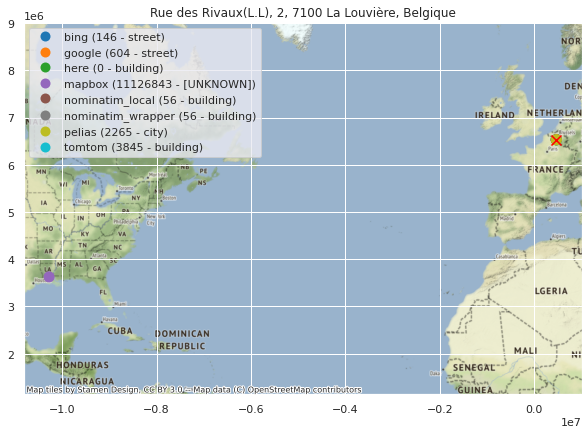

street housenumber postcode      city  \
874   Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
2735  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
3735  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
4735  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
5728  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
6728  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
7727  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   

                                                address  \
874   Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
2735  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
3735  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
4735  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
5728  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
6728  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
7727  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   

                                               location           geocoder  \
874   (65, Rue de la Croix Rouge, Golzinne, Bossière...  nominatim_wrapper   
2735  (Rue de la Croix-Rouge 65, 5032 Gembloux, Belg...               here   
3735  (Rue de la Croix Rouge 65, Gembloux, Walloon R...               bing   
4735  (Rue De La Croix Rouge, 5032 Gembloux, Namur, ...             mapbox   
5728  (Rue de la Croix Rouge 65, 5032 Gembloux, (50....             tomtom   
6728  (Hautes-Pyrénées, France, (43.0193924, 0.14949...             google   
7727                  (Jembloux, (50.557298, 4.691263))             pelias   

      duration precision                           point  is_in_belgium  \
874   0.360674  building  POINT (524748.479 6536502.524)           True   
2735  0.093710  building  POINT (524748.948 6536502.095)           True   
3735  0.273198  building  POINT (524748.480 6536502.516)           True   
4735  0.208045    street  POINT (524100.484 6536724.748)           True   
5728  0.360783  building  POINT (524748.948 6536502.095)           True   
6728  0.114495      city   POINT (16642.130 5314924.034)          False   
7727  0.024277      city  POINT (522229.008 6543355.330)           True   

                        median_point  nb_points  dist_to_median  
874   POINT (524748.714 6536502.306)        4.0    3.206694e-01  
2735  POINT (524748.714 6536502.306)        4.0    3.143046e-01  
3735  POINT (524748.714 6536502.306)        4.0    3.143046e-01  
4735  POINT (524748.714 6536502.306)        4.0    6.853334e+02  
5728  POINT (524748.714 6536502.306)        4.0    3.143046e-01  
6728  POINT (524748.714 6536502.306)        4.0    1.323037e+06  
7727  POINT (524748.714 6536502.306)        4.0    7.301565e+03

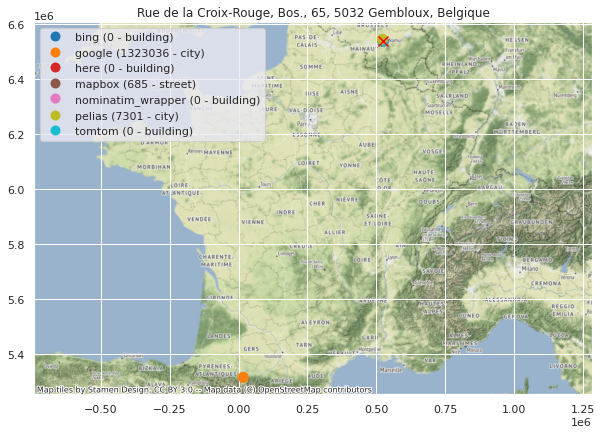

street housenumber postcode           city  \
155   Quai du Halage          42     4420  Saint-Nicolas   
1135  Quai du Halage          42     4420  Saint-Nicolas   
2013  Quai du Halage          42     4420  Saint-Nicolas   
3013  Quai du Halage          42     4420  Saint-Nicolas   
4013  Quai du Halage          42     4420  Saint-Nicolas   
5013  Quai du Halage          42     4420  Saint-Nicolas   
6006  Quai du Halage          42     4420  Saint-Nicolas   
7006  Quai du Halage          42     4420  Saint-Nicolas   

                                               address  \
155   Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
1135  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
2013  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
3013  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
4013  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
5013  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
6006  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
7006  Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   

                                               location           geocoder  \
155   (Quai du Halage, Tilleur, Saint-Nicolas, Liège...  nominatim_wrapper   
1135  (Quai du Halage, Tilleur, Saint-Nicolas, Liège...    nominatim_local   
2013  (Quai du Halage 41, 4420 Saint-Nicolas, Belgiq...               here   
3013  (Quai du Halage 42, Flémalle-Grande, Walloon R...               bing   
4013  (Quai Du Halage 42, 4420 Saint-Nicolas, Liege,...             mapbox   
5013  (Quai du Halage, 4420 Saint-Nicolas, (50.61671...             tomtom   
6006  (Quai du Halage 42, 4420 Saint-Nicolas, Belgiu...             google   
7006                (St Nicolas, (51.163886, 4.139404))             pelias   

      duration precision                           point  is_in_belgium  \
155   0.040731    street  POINT (614993.911 6553896.529)           True   
1135  0.021096    street  POINT (614993.911 6553896.529)           True   
2013  0.103140  building  POINT (614865.415 6554007.271)           True   
3013  0.226350  building  POINT (606823.606 6549509.414)           True   
4013  0.205701  building  POINT (614822.223 6553989.551)           True   
5013  0.219239    street  POINT (615159.298 6553772.174)           True   
6006  0.108196  building  POINT (614829.336 6553988.481)           True   
7006  0.028780      city  POINT (460796.345 6650334.618)           True   

                        median_point  nb_points  dist_to_median  
155   POINT (614825.780 6553989.016)        4.0      191.890475  
1135  POINT (614825.780 6553989.016)        4.0      191.890475  
2013  POINT (614825.780 6553989.016)        4.0       43.637312  
3013  POINT (614825.780 6553989.016)        4.0     9170.693636  
4013  POINT (614825.780 6553989.016)        4.0        3.596688  
5013  POINT (614825.780 6553989.016)        4.0      397.812847  
6006  POINT (614825.780 6553989.016)        4.0        3.596688  
7006  POINT (614825.780 6553989.016)        4.0   181679.777928

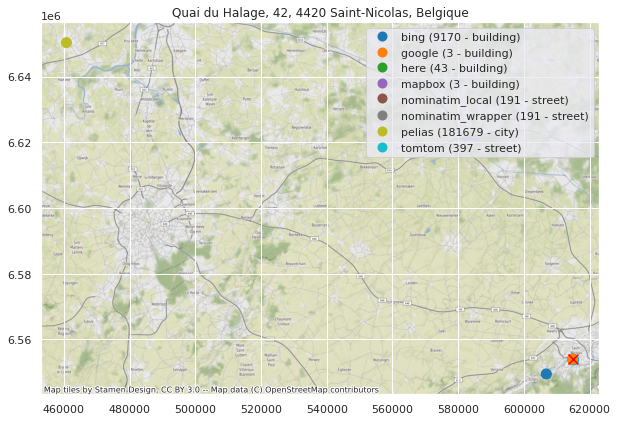

street housenumber postcode           city  \
794   Rue Pavé du Gosson        243/     4420  Saint-Nicolas   
1686  Rue Pavé du Gosson        243/     4420  Saint-Nicolas   
2655  Rue Pavé du Gosson        243/     4420  Saint-Nicolas   
3655  Rue Pavé du Gosson        243/     4420  Saint-Nicolas   
4655  Rue Pavé du Gosson        243/     4420  Saint-Nicolas   
6648  Rue Pavé du Gosson        243/     4420  Saint-Nicolas   
7647  Rue Pavé du Gosson        243/     4420  Saint-Nicolas   

                                                address  \
794   Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
1686  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
2655  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
3655  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
4655  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
6648  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
7647  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   

                                               location           geocoder  \
794   (243, Rue Pavé du Gosson, Montegnée, Saint-Nic...  nominatim_wrapper   
1686  (243, Rue Pavé du Gosson, Montegnée, Saint-Nic...    nominatim_local   
2655  (Rue Pavé du Gosson 243, 4420 Saint-Nicolas, B...               here   
3655  (Rue Pavé du Gosson 243, Saint-Nicolas, Walloo...               bing   
4655  (Rue Pavé Du Gosson 243, 4420 Saint-Nicolas, L...             mapbox   
6648  (Rue Pavé du Gosson 243, 4420 Saint-Nicolas, B...             google   
7647                (St Nicolas, (51.163886, 4.139404))             pelias   

      duration precision                           point  is_in_belgium  \
794   0.074841  building  POINT (615096.804 6556986.364)           True   
1686  0.011110  building  POINT (615096.804 6556986.364)           True   
2655  0.043417  building  POINT (615096.960 6556985.161)           True   
3655  0.310077  building  POINT (615097.316 6556985.705)           True   
4655  0.214596  building  POINT (615097.071 6556986.039)           True   
6648  0.110045  building  POINT (615081.419 6556996.219)           True   
7647  0.020646      city  POINT (460796.345 6650334.618)           True   

                        median_point  nb_points  dist_to_median  
794   POINT (615096.960 6556986.039)        5.0        0.360215  
1686  POINT (615096.960 6556986.039)        5.0        0.360215  
2655  POINT (615096.960 6556986.039)        5.0        0.877557  
3655  POINT (615096.960 6556986.039)        5.0        0.487953  
4655  POINT (615096.960 6556986.039)        5.0        0.111319  
6648  POINT (615096.960 6556986.039)        5.0       18.577498  
7647  POINT (615096.960 6556986.039)        5.0   180340.335987

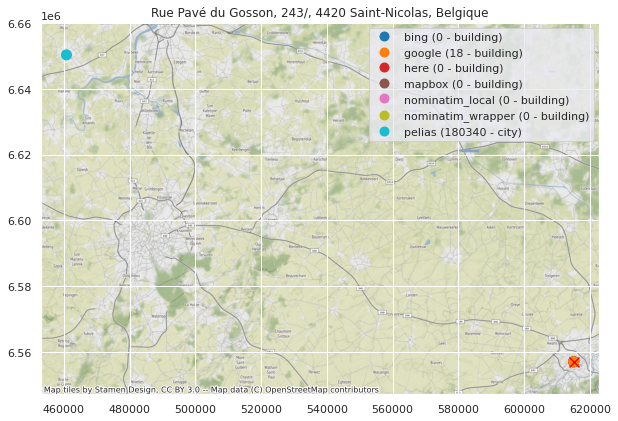

In [256]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

In [257]:
# geocoders["bing"].geocode("Rue Le Lorrain, 4, 1080 Molenbeek-Saint-Jean, Belgique")

In [258]:
# geocoded_data.loc[25].location.raw

## Median pertinence

How many close to median ?

In [259]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()

nb_close_to_median

address
't Vlietje, 4, 2800 Mechelen, Belgique                8
Aalstersesteenweg, 362, 9400 Ninove, Belgique         5
Aaltersesteenweg, 122, 9800 Deinze, Belgique          8
Aarschotsesteenweg, 22, 3012 Leuven, Belgique         8
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique     6
                                                     ..
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique    5
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique     6
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique    5
rue des Maraîchers, 9, 1070 Anderlecht, Belgique      7
rue du Chenia, 15, 7170 Manage, Belgique              1
Name: close_to_median, Length: 1000, dtype: int64

In [260]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [261]:
median_points.nb_close_to_median.value_counts()

8    436
7    151
6    133
5    104
4     74
3     47
2     16
0      8
1      2
Name: nb_close_to_median, dtype: int64

In [262]:
median_points[median_points.nb_close_to_median>=2]

address  \
0               't Vlietje, 4, 2800 Mechelen, Belgique   
1        Aalstersesteenweg, 362, 9400 Ninove, Belgique   
2         Aaltersesteenweg, 122, 9800 Deinze, Belgique   
3        Aarschotsesteenweg, 22, 3012 Leuven, Belgique   
4    Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique   
..                                                 ...   
965          Zur Domäne, 39, 4750 Bütgenbach, Belgique   
966  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
967  de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique   
968  de Smet de Naeyerlaan, 526, 1020 Brussel, Belg...   
969   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   

                       median_point  nb_points  nb_close_to_median  
0    POINT (499196.315 6626069.331)          6                   8  
1    POINT (449065.119 6596429.049)          5                   5  
2    POINT (389868.103 6620321.889)          6                   8  
3    POINT (524091.923 6601928.128)          6                   8  
4    POINT (527891.497 6611051.200)          5                   6  
..                              ...        ...                 ...  
965  POINT (692725.000 6517833.816)          6                   7  
966  POINT (498587.754 6595071.625)          5                   5  
967  POINT (480158.345 6604332.636)          5                   6  
968  POINT (483041.653 6600914.669)          5                   5  
969  POINT (478803.603 6592983.817)          6                   7  

[961 rows x 4 columns]

In [263]:
nb_close_to_median.value_counts()

8    436
7    151
6    133
5    104
4     74
3     47
0     37
2     16
1      2
Name: close_to_median, dtype: int64

In [264]:
geocoded_data = geocoded_data.merge(median_points, how="left")


In [265]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [266]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

961

street housenumber postcode     city  \
746   Antoon van Osslaan           1     1120  Brussel   
1644  Antoon van Osslaan           1     1120  Brussel   
2607  Antoon van Osslaan           1     1120  Brussel   
3607  Antoon van Osslaan           1     1120  Brussel   
4607  Antoon van Osslaan           1     1120  Brussel   
5601  Antoon van Osslaan           1     1120  Brussel   
6600  Antoon van Osslaan           1     1120  Brussel   
7599  Antoon van Osslaan           1     1120  Brussel   

                                            address  \
746   Antoon van Osslaan, 1, 1120 Brussel, Belgique   
1644  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
2607  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
3607  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
4607  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
5601  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
6600  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
7599  Antoon van Osslaan, 1, 1120 Brussel, Belgique   

                                               location           geocoder  \
746   (Scania Belgium nv-sa, 1, Avenue Antoon van Os...  nominatim_wrapper   
1644  (Scania Belgium nv-sa, 1, Avenue Antoon van Os...    nominatim_local   
2607  (Antoon van Osslaan 1, 1120 Brussel, België, B...               here   
3607  (Avenue Antoon Van Oss 1/17, Brussels, Brussel...               bing   
4607  (Avenue Antoon Van Oss - Antoon Van Osslaan 1,...             mapbox   
5601  (Antoon van Osslaan 1A, 1000 Brussel, (50.9055...             tomtom   
6600  (Av. Antoon Van Oss 1, 1120 Bruxelles, Belgium...             google   
7599                   (Brussel, (50.843183, 4.371755))             pelias   

      duration precision                           point  is_in_belgium  \
746   0.043004  building  POINT (490653.796 6605555.540)           True   
1644  0.020403  building  POINT (490653.796 6605555.540)           True   
2607  0.045426  building  POINT (490129.699 6604908.987)           True   
3607  0.232463  building  POINT (490392.936 6605140.517)           True   
4607  0.162574  building  POINT (490003.908 6604874.916)           True   
5601  0.214580  building  POINT (490419.130 6604603.586)           True   
6600  0.102215  building  POINT (490133.406 6604672.168)           True   
7599  0.024042      city  POINT (486661.540 6593601.349)           True   

                        median_point  nb_points dist_to_median  \
746   POINT (490263.171 6604891.952)        6.0           <NA>   
1644  POINT (490263.171 6604891.952)        6.0           <NA>   
2607  POINT (490263.171 6604891.952)        6.0           <NA>   
3607  POINT (490263.171 6604891.952)        6.0           <NA>   
4607  POINT (490263.171 6604891.952)        6.0           <NA>   
5601  POINT (490263.171 6604891.952)        6.0           <NA>   
6600  POINT (490263.171 6604891.952)        6.0           <NA>   
7599  POINT (490263.171 6604891.952)        6.0           <NA>   

      nb_close_to_median  
746                  0.0  
1644                 0.0  
2607                 0.0  
3607                 0.0  
4607                 0.0  
5601                 0.0  
6600                 0.0  
7599                 0.0

No median point


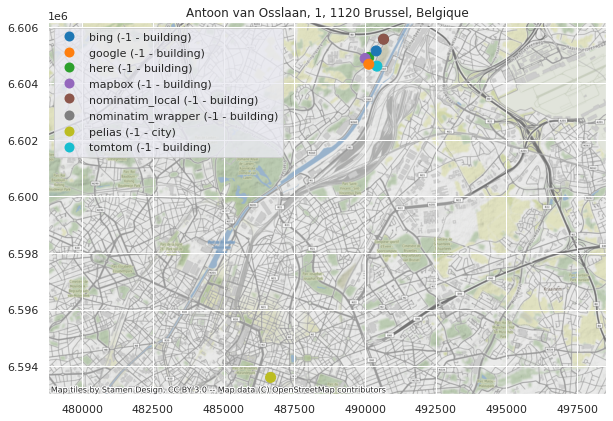

street housenumber postcode   city  \
765   Boulevard du Rectorat         27B     4000  Liège   
1662  Boulevard du Rectorat         27B     4000  Liège   
2626  Boulevard du Rectorat         27B     4000  Liège   
3626  Boulevard du Rectorat         27B     4000  Liège   
4626  Boulevard du Rectorat         27B     4000  Liège   
5620  Boulevard du Rectorat         27B     4000  Liège   
6619  Boulevard du Rectorat         27B     4000  Liège   
7618  Boulevard du Rectorat         27B     4000  Liège   

                                               address  \
765   Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
1662  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
2626  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
3626  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
4626  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
5620  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
6619  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   
7618  Boulevard du Rectorat, 27B, 4000 Liège, Belgique   

                                               location           geocoder  \
765   (Boulevard du Rectorat, Liège, Wallonie, 4000,...  nominatim_wrapper   
1662  (Boulevard du Rectorat, Liège, Wallonie, 4000,...    nominatim_local   
2626  (Boulevard du Rectorat 27B, 4000 Liège, Belgiq...               here   
3626  (Boulevard du Rectorat, Liège, Walloon Region ...               bing   
4626  (Boulevard Du Rectorat 27b, 4000 Liège, Liege,...             mapbox   
5620  (Rue du Pâquier 27, 4000 Liège, (50.6432, 5.58...             tomtom   
6619  (Bd du Rectorat 27b, 4000 Liège, Belgium, (50....             google   
7618    (Boulevard Du Rectorat 27, (50.57836, 5.57602))             pelias   

      duration precision                           point  is_in_belgium  \
765   0.053221    street  POINT (622356.015 6546838.054)           True   
1662  0.030810    street  POINT (622356.015 6546838.054)           True   
2626  0.050138  building  POINT (618980.084 6547637.704)           True   
3626  0.224540    street  POINT (619371.373 6548000.703)           True   
4626  0.162962  building  POINT (620719.262 6547046.150)           True   
5620  0.293309  building  POINT (621398.756 6558420.969)           True   
6619  0.100369  building  POINT (620664.192 6546973.891)           True   
7618  0.016705  building  POINT (620719.707 6547046.676)           True   

                        median_point  nb_points dist_to_median  \
765   POINT (620691.727 6547341.927)        4.0           <NA>   
1662  POINT (620691.727 6547341.927)        4.0           <NA>   
2626  POINT (620691.727 6547341.927)        4.0           <NA>   
3626  POINT (620691.727 6547341.927)        4.0           <NA>   
4626  POINT (620691.727 6547341.927)        4.0           <NA>   
5620  POINT (620691.727 6547341.927)        4.0           <NA>   
6619  POINT (620691.727 6547341.927)        4.0           <NA>   
7618  POINT (620691.727 6547341.927)        4.0           <NA>   

      nb_close_to_median  
765                  0.0  
1662                 0.0  
2626                 0.0  
3626                 0.0  
4626                 0.0  
5620                 0.0  
6619                 0.0  
7618                 0.0

No median point


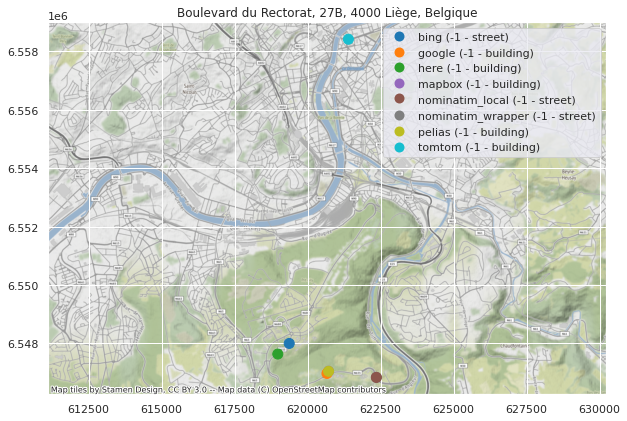

In [267]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:10].index:
    #print(a)
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)
  

# Statistics

In [268]:
# geocoded_data


## Add selectors

In [269]:
geocoded_data["has_median"] = geocoded_data.dist_to_median.notnull()
geocoded_data["has_median"].value_counts()

True     7557
False     292
Name: has_median, dtype: int64

In [270]:
geocoded_data[geocoded_data["has_median"]].address.nunique()

961

In [271]:
# geocoded_data["is_median_reliable"] =   geocoded_data["nb_close_to_median"]>=2
# geocoded_data.is_median_reliable.value_counts()

In [272]:
geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.995)
geocoded_data.is_value_normal.value_counts() # / geocoded_data.shape[0]

True     7519
False     330
Name: is_value_normal, dtype: int64

In [273]:
geocoded_data["less_than_10km"]    = geocoded_data.dist_to_median < 10000
geocoded_data.less_than_10km.value_counts() # / geocoded_data.shape[0]

True     7501
False     348
Name: less_than_10km, dtype: int64

<AxesSubplot:>

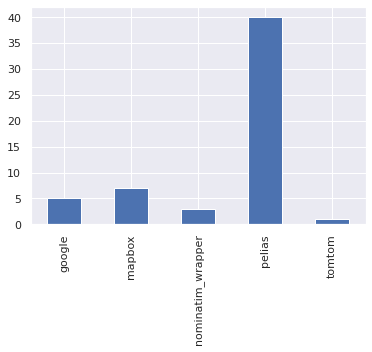

In [274]:
geocoded_data[(geocoded_data.geocoder != "trillium") & (geocoded_data.dist_to_median > 10000)].geocoder.value_counts().sort_index().plot.bar()

In [275]:
geocoded_data.dist_to_median.quantile(0.99)

8367.601366328017

In [276]:
pd.crosstab(geocoded_data.is_value_normal, geocoded_data.is_in_belgium)

is_in_belgium    False  True
is_value_normal             
False                4   326
True                 0  7519

In [277]:
#Q3 + (Q3-Q1 = IQR) * 1.5 
top_whisker = geocoded_data.dist_to_median.quantile(0.75) + (geocoded_data.dist_to_median.quantile(0.75) - geocoded_data.dist_to_median.quantile(0.25))*1.5
geocoded_data["is_below_top_whisker"]    = geocoded_data.dist_to_median < top_whisker
geocoded_data.is_below_top_whisker.value_counts()

True     6116
False    1733
Name: is_below_top_whisker, dtype: int64

In [278]:
geocoded_data.dist_to_median.quantile(0.75) 

23.500549913780066

In [279]:
# geocoded_data[geocoded_data.is_below_top_whisker].dist_to_median.hist(bins=100)

In [280]:
top_whisker

57.96043324907774

In [281]:
# geocoded_data[~geocoded_data.is_below_top_whisker]

In [282]:
geocoded_data.dist_to_median.quantile(0.99)

8367.601366328017

In [283]:
# match_per_addr = geocoded_data.groupby("address").geocoder.count()
# geocoded_data["has_enough_matches"] = geocoded_data.address.isin(match_per_addr[match_per_addr>=3].index)
# geocoded_data["has_enough_matches"].value_counts()

In [284]:
# pd.crosstab(geocoded_data["is_median_reliable"] , geocoded_data["has_enough_matches"])

In [285]:
geocoded_data["is_reliable"] = geocoded_data["is_value_normal"] & \
                               geocoded_data["is_in_belgium"]

#geocoded_data["is_median_reliable"] & \
                               #geocoded_data["has_enough_matches"] &  \

<AxesSubplot:>

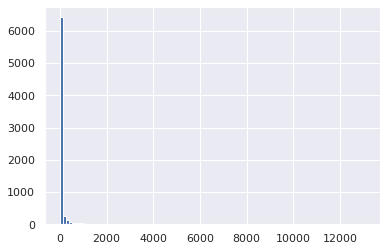

In [286]:
geocoded_data[geocoded_data.is_reliable].dist_to_median.hist(bins=100)

In [287]:
# pd.crosstab(geocoded_data["is_in_belgium"] , geocoded_data["is_value_normal"])

In [288]:
# match_per_addr.value_counts().plot.bar()

In [289]:
geocoded_data[~geocoded_data.is_value_normal].geocoder.value_counts()

pelias               64
mapbox               45
google               42
nominatim_wrapper    41
here                 39
bing                 39
tomtom               39
nominatim_local      21
Name: geocoder, dtype: int64

In [290]:
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
7844        Lichterweg           3     2030        Antwerpen   
7845  Grote Markt(Kor)          41     8500         Kortrijk   
7846     Heerweg-Noord          72     9052             Gent   
7847        Mechelbaan         750     2580            Putte   
7848     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
7844            Lichterweg, 3, 2030 Antwerpen, Belgique   
7845      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
7846             Heerweg-Noord, 72, 9052 Gent, Belgique   
7847              Mechelbaan, 750, 2580 Putte, Belgique   
7848           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location           geocoder  \
0     (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1     (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2     (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3     (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4     (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
...                                                 ...                ...   
7844                 (Antwerpen, (51.246664, 4.402453))             pelias   
7845                  (Kortrijk, (50.837035, 3.275675))             pelias   
7846             (Heerweg-Noord 72, (51.00594, 3.7168))             pelias   
7847              (Mechelbaan 750, (51.03833, 4.57662))             pelias   
7848       (Dikkebusseweg 126, (50.8419357, 2.8719322))             pelias   

      duration precision                           point  is_in_belgium  \
0     0.075832    street  POINT (498759.064 6595272.461)           True   
1     0.030597  building  POINT (497811.825 6595976.732)           True   
2     0.055077    street  POINT (478780.031 6493264.898)           True   
3     0.082737  building  POINT (607319.913 6542692.124)           True   
4     0.071004  building  POINT (515079.967 6692438.032)           True   
...        ...       ...                             ...            ...   
7844  0.018700      city  POINT (490078.826 6665042.258)           True   
7845  0.014896      city  POINT (364646.473 6592517.569)           True   
7846  0.015381  building  POINT (413752.283 6622344.507)           True   
7847  0.015275  building  POINT (509467.008 6628076.659)           True   
7848  0.019511    street  POINT (319702.030 6593381.461)           True   

                        median_point  nb_points dist_to_median  \
0     POINT (498587.754 6595071.625)        5.0     263.973868   
1     POINT (497812.970 6595976.097)        6.0       1.309216   
2     POINT (479073.247 6493719.741)        4.0     541.163092   
3     POINT (607319.067 6542691.616)        5.0       0.986864   
4     POINT (515081.234 6692443.448)        6.0       5.561728   
...                              ...        ...            ...   
7844                            None        NaN            NaN   
7845  POINT (363455.644 6590773.571)        4.0    2111.777243   
7846  POINT (413752.974 6622343.800)        5.0       0.988489   
7847  POINT (509464.782 6628071.348)    

In [291]:
geocoded_data[["has_median", "is_value_normal", #"is_median_reliable", 
               #"has_enough_matches",
               "is_in_belgium", #"has_enough_matches", 
               "is_below_top_whisker", "is_reliable"]].sum()/geocoded_data.shape[0]

has_median              0.962798
is_value_normal         0.957956
is_in_belgium           0.999490
is_below_top_whisker    0.779208
is_reliable             0.957956
dtype: float64

In [292]:
geocoded_data[~geocoded_data.is_reliable & (geocoded_data.geocoder=="nominatim_wrapper")]

street housenumber postcode  \
39               Rue Taille Gabelle           2     6530   
62                Rue des Ecoles(M)          34     7870   
72           Boulevard Mairaux(L.L)          21     7100   
96               Rue de l'Industrie           2     1301   
101                   Karveelstraat          40     8380   
172             Rue des Battes(LAN)          24     4600   
196           Place Sainte Ode(AMA)           3     4540   
212      Marloie, Rue Saint Isidore         101     6900   
223              Bloempotstraat(MD)         19B     9170   
232                   rue du Chenia          15     7170   
254            Tienne Beaudoin(AUV)           1     5060   
257   Rue du Pont-à-la Cambe(J.-S.)           9     1370   
272         Allée J.F. Kennedy(Cha)           8     5650   
305        Chaussée de Tournai(Irc)         184     7801   
362         Avenue Léopold III(PER)          17     7134   
373                        Rettigny          32     6673   
391             Rue Albert 1er(GER)           8     6280   
393               Rue des Phlox(NN)       51-53     5100   
400    Rue Antoine de Saint-Exupéry           2     6041   
433              Rue du Relais(CER)           1     4632   
481                 Watervoort(HRT)          75     2200   
554  Rue de la Terre à Briques(MAR)         29B     7522   
558           Rue Dieudonné Lefèvre           2     1020   
561                Rue Conreur(L.L)          47     7100   
565        Rue de la Gare,Ste-Marie          31     6740   
584       Rue des Droits de l'Homme         5-3     7160   
610         Boulevard André Delvaux          15     7000   
621               Rue de Baume(L.L)         377     7100   
624              Rue des Heids(AYE)          11     4630   
648           Chaussée de Lille(OR)       479/2     7501   
727         Rue du Mont d'Orcq(FRY)          14     7503   
742        Avenue Reine Astrid(W-B)          16     1440   
746              Antoon van Osslaan           1     1120   
764                       Zandvoort          10     2030   
765           Boulevard du Rectorat         27B     4000   
834   Industrieterrein Kanaal-Noord        1402     3960   
917    Rue Isidore-Derèse,Mornimont         155     5190   
925                      Satenrozen           8     2550   
936                Rue de Lassus(H)          46     7712   
944               Franseweg (Heide)          33     2920   
989                      Lichterweg           3     2030   

                        city  \
39                     Thuin   
62            Lens (Hainaut)   
72               La Louvière   
96                     Wavre   
101                   Brugge   
172                     Visé   
196                     Amay   
212        Marche-en-Famenne   
223         Sint-Gillis-Waas   
232                   Manage   
254              Sambreville   
257                 Jodoigne   
272                 Walcourt   
305                      Ath   
362                   Binche   
373                    Gouvy   
391                Gerpinnes   
393                    Namur   
400                Charleroi   
433                 Soumagne   
481                Herentals   
554                  Tournai   
558                Bruxelles   
561              La Louvière   
565                   Etalle   
584  Chapelle-lez-Herlaimont   
610                     Mons   
621              La Louvière   
624                 Soumagne   
648                  Tournai   
727                  Tournai   
742        Braine-le-Château   
746                  Brussel   
764                Antwerpen   
765                    Liège   
834                     Bree   
917       Jemeppe-sur-Sambre   
925                  Kontich   
936                 Mouscron   
944                Kalmthout   
989                Antwerpen   

                                               address  \
39         Rue Taille Gabelle, 2, 6530 Thuin, Belgique   
62   Rue des Ecoles(M), 34, 7870 Lens (Hainaut)

In [293]:
geocoded_data.geocoder.value_counts()

here                 1000
bing                 1000
mapbox               1000
google               1000
pelias                999
nominatim_wrapper     994
tomtom                993
nominatim_local       863
Name: geocoder, dtype: int64

## Matching rate

In [294]:
# geocoded_data.groupby("geocoder").address.count()/ data.shape[0]
data

street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3            Rue du Hock(N), 36, 4121 Neupré, Belgique  
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
..                                                 ...  
995            Lichterweg, 3, 2030 Antwerpen, Belgique  
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique  
997             Heerweg-Noord, 72, 9052 Gent, Belgique  
998              Mechelbaan, 750, 2580 Putte, Belgique  
999           Dikkebusseweg, 126, 8900 Ieper, Belgique  

[1000 rows x 5 columns]

In [295]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

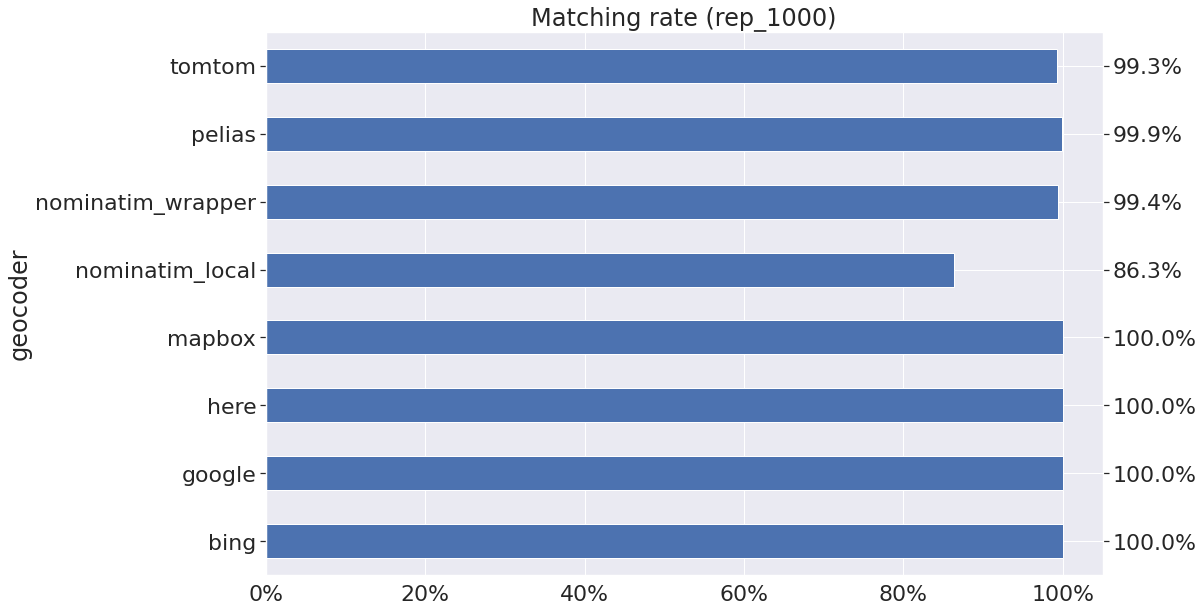

In [296]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')    

plt.figure(figsize=(15,10))
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)

mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf.savefig( bbox_inches='tight')

sbn.set(font_scale=1)



In [297]:
# # Only reliable records
# mr = (geocoded_data[geocoded_data.is_reliable].groupby("geocoder").address.count()/ geocoded_data[geocoded_data.is_reliable].address.nunique())

# plt.figure(figsize=(15,10))
# sbn.set(font_scale=2)

# mr_plot=mr.rename("matching rate").plot.barh(title="Matching rate (only reliable)")
# show_values_on_hbars(mr_plot)
# mr_plot.xaxis.set_major_formatter('{x:.0%}')
# # mr.reset_index()
# plt.savefig(f"{fig_path}/matching_rate_reliable_{dataset}.png", bbox_inches='tight')

# pdf.add_page()
# pdf.image(f"{fig_path}/matching_rate_reliable_{dataset}.png",0,0, 210)

# sbn.set(font_scale=1)

<AxesSubplot:title={'center':'Number of success per address'}>

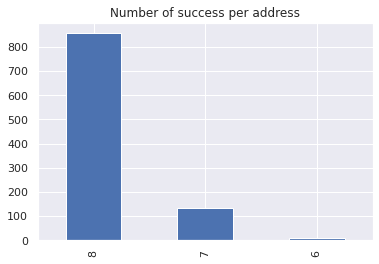

In [298]:
geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Precision

In [299]:
# geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack().plot.bar(stacked=True)
# plt.savefig(f"{fig_path}/matching_rate_precision_{dataset}.png")
mr

geocoder
bing                 1.000
google               1.000
here                 1.000
mapbox               1.000
nominatim_local      0.863
nominatim_wrapper    0.994
pelias               0.999
tomtom               0.993
Name: address, dtype: float64

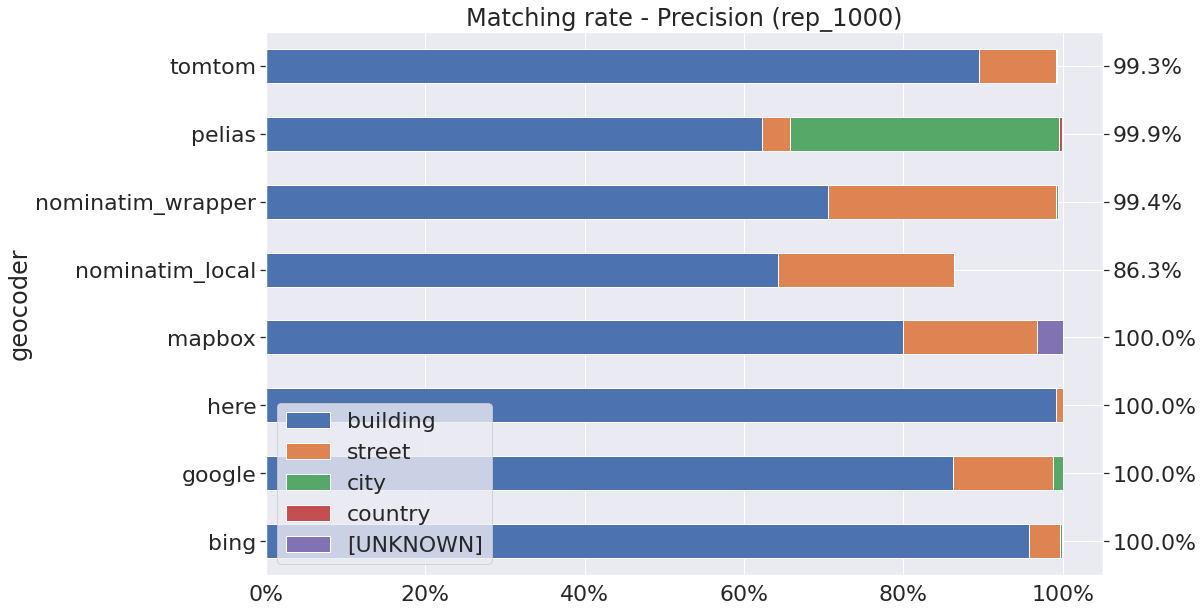

In [300]:
sbn.set(font_scale=2)
mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/data.shape[0]
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)
mr_prec_plot= mr_prec.plot.barh(stacked=True, figsize=(15,10), title=f"Matching rate - Precision ({dataset})")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

plt.legend(loc='lower left')

show_values_on_hbars(mr_prec_plot, mr)

pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)


In [301]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))




precision          building  street  city country [UNKNOWN]
geocoder                                                   
bing                  95.7%    3.9%  0.3%              0.1%
google                86.2%   12.6%  1.2%                  
here                  99.2%    0.8%                        
mapbox                79.9%   16.9%                    3.2%
nominatim_local       64.3%   22.0%                        
nominatim_wrapper     70.6%   28.6%  0.2%                  
pelias                62.2%    3.6% 33.7%    0.4%          
tomtom                89.5%    9.7%  0.1%

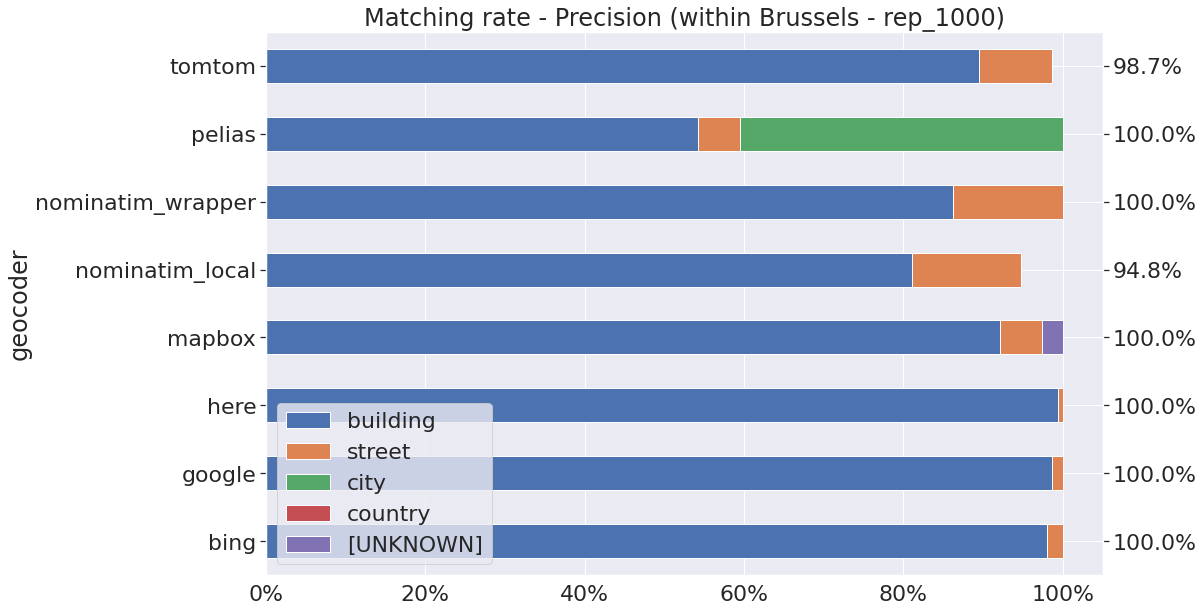

In [302]:
bru_boundaries = gpd.read_file("data/boundaries.geojson")
bru_boundaries = bru_boundaries[bru_boundaries.name == "BRU"].geometry.iloc[0].simplify(1000).buffer(1000)

addr_in_bru = geocoded_data[geocoded_data.point.within(bru_boundaries)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 


sbn.set(font_scale=2)
mr_prec = geocoded_data_bru.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/geocoded_data_bru.address.nunique()
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)

mr_prec_plot= mr_prec.plot.barh(stacked=True, figsize=(15,10), title=f"Matching rate - Precision (within Brussels - {dataset})")
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

plt.legend(loc='lower left')



mr_bru = (geocoded_data_bru.groupby("geocoder").address.count()/ geocoded_data_bru.address.nunique())

show_values_on_hbars(mr_prec_plot, mr_bru)


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)

In [303]:
# geocoded_data[geocoded_data.point.within(bru_boundaries)]

In [304]:
mr_prec

precision          building    street      city  country  [UNKNOWN]
geocoder                                                           
bing               0.980392  0.019608       NaN      NaN        NaN
google             0.986928  0.013072       NaN      NaN        NaN
here               0.993464  0.006536       NaN      NaN        NaN
mapbox             0.921569  0.052288       NaN      NaN   0.026144
nominatim_local    0.810458  0.137255       NaN      NaN        NaN
nominatim_wrapper  0.862745  0.137255       NaN      NaN        NaN
pelias             0.542484  0.052288  0.405229      NaN        NaN
tomtom             0.895425  0.091503       NaN      NaN        NaN

In [305]:
geocoded_data[(geocoded_data.geocoder=="pelias") & (geocoded_data.precision == "city")]

street housenumber postcode                city  \
6850                  de Burburelaan          46     1970     Wezembeek-Oppem   
6851                 Nachtegalenlaan          35     1950            Kraainem   
6852                   Rue Tilia(ST)          12     6511            Beaumont   
6853                  Rue du Hock(N)          36     4121              Neupré   
6859            Rue de l'Eglise(PAC)         129     6230       Pont-à-Celles   
...                              ...         ...      ...                 ...   
7839  Libramont,Avenue de Houffalize         42b     6800  Libramont-Chevigny   
7840  Rue Prisonniers de Guerre(FLM)          22     6141   Fontaine-l'Evêque   
7841           Vlasbloemstraat(Woes)           6     8640            Vleteren   
7844                      Lichterweg           3     2030           Antwerpen   
7845                Grote Markt(Kor)          41     8500            Kortrijk   

                                                address  \
6850  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
6851       Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
6852         Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
6853          Rue du Hock(N), 36, 4121 Neupré, Belgique   
6859  Rue de l'Eglise(PAC), 129, 6230 Pont-à-Celles,...   
...                                                 ...   
7839  Libramont,Avenue de Houffalize, 42b, 6800 Libr...   
7840  Rue Prisonniers de Guerre(FLM), 22, 6141 Fonta...   
7841  Vlasbloemstraat(Woes), 6, 8640 Vleteren, Belgique   
7844            Lichterweg, 3, 2030 Antwerpen, Belgique   
7845      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   

                                        location geocoder  duration precision  \
6850     (Wezembeek-Oppem, (50.844132, 4.49277))   pelias  0.121541      city   
6851           (Kraainem, (50.855488, 4.469186))   pelias  0.024279      city   
6852           (Beaumont, (50.236346, 4.238044))   pelias  0.034006      city   
6853                 (Ehein, (50.54573, 5.4451))   pelias  0.030391      city   
6859       (Pont-à-Celles, (50.511885, 4.35645))   pelias  0.027534      city   
...                                          ...      ...       ...       ...   
7839          (Libramont, (49.917587, 5.376336))   pelias  0.015672      city   
7840  (Forchies-la-Marche, (50.43368, 4.325433))   pelias  0.019114      city   
7841           (Vleteren, (50.915441, 2.732525))   pelias  0.012526      city   
7844          (Antwerpen, (51.246664, 4.402453))   pelias  0.018700      city   
7845           (Kortrijk, (50.837035, 3.275675))   pelias  0.014896      city   

                               point  is_in_belgium  \
6850  POINT (500132.869 6593768.653)           True   
6851  POINT (497507.510 6595770.923)           True   
6852  POINT (471776.900 6487307.861)           True   
6853  POINT (606145.759 6541328.613)           True   
6859  POINT (484957.796 6535401.813)           True   
...                              ...            ...   
7839  POINT (598490.986 6432015.575)           True   
7840  POINT (481504.999 6521723.101)           True   
7841  POINT (304183.292 6606349.823)           True   
7844  POINT (490078.826 6665042.258)           True   
7845  POINT (364646.473 6592517.569)           True   

                        median_point  nb_points dist_to_median  \
6850  POINT (498587.754 6595071.625)        5.0    2021.166698   
6851  POINT (497812.970 6595976.097)        6.0     367.970838   
6852  POINT (479073.247 6493719.741)        4.0    9713.335327   
6853  POINT (607319.067 6542691.616)        5.0    1798.451745   
6859  POINT (486433.402 6534644.743)        3.0    1658.484372   
...                              ...        ...            ...   
7839  POINT (599027.640 6433219.469)        6.0    1318.088705   
7840  POINT (481715.059 6521565.815)        3.0     262.419563   
7841  POINT (311045.582 6605752.872)        3.0    6888.205453   
7844                            None        NaN       

In [306]:
# geocoders["pelias"].geocode("Rue de la loi, 16, 1000 bruxelles").raw


In [307]:
# geocoders["nominatim"].geocode("Rue Nicolas Arnold, 4800 Verviers")

## Distance to median

### Average

geocoder
bing                    65.125721
google                1654.739182
here                    23.164723
mapbox               23484.413263
nominatim_local        187.312491
nominatim_wrapper      383.184361
pelias                3318.409605
tomtom                  77.534278
Name: dist_to_median, dtype: float64

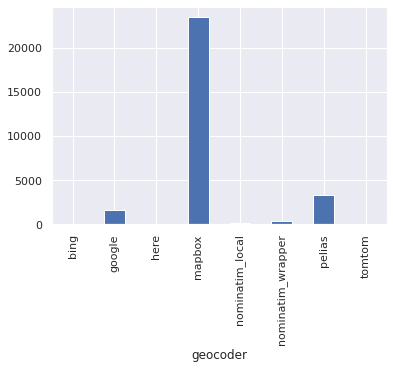

In [308]:
d2m = geocoded_data[geocoded_data.geocoder!= "trillium"].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

In [309]:
# geocoded_data.pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

In [310]:
# # skipping top 1%
# d2m = geocoded_data[geocoded_data.is_value_normal].groupby("geocoder").dist_to_median.mean()
# d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_skip1pc_{dataset}.png")
# d2m

In [311]:
# geocoded_data[geocoded_data.is_value_normal].pivot(index="address", columns="geocoder", values="dist_to_median").plot.box()

geocoder
bing                   65.125721
google                278.299772
here                   23.164723
mapbox                280.802175
nominatim_local       187.312491
nominatim_wrapper     383.184361
pelias               3318.409605
tomtom                 77.534278
Name: dist_to_median, dtype: float64

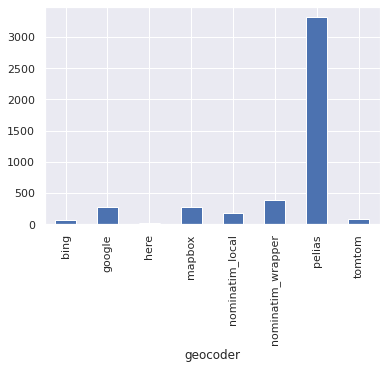

In [312]:
# skipping non reliable median

d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

geocoder
bing                   65.125721
google                182.291007
here                   23.164723
mapbox                162.599984
nominatim_local       187.312491
nominatim_wrapper     247.139030
pelias               1318.290110
tomtom                 61.317422
Name: dist_to_median, dtype: float64

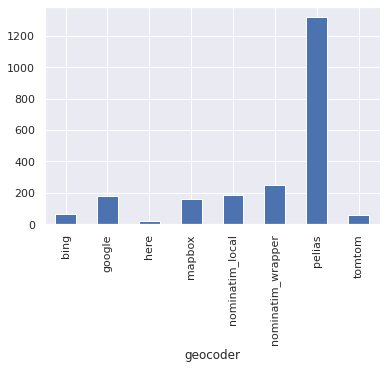

In [313]:
d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

In [314]:
geocoded_data[geocoded_data.dist_to_median>100000]

street housenumber postcode             city  \
96              Rue de l'Industrie           2     1301            Wavre   
4111           Rue des Rivaux(L.L)           2     7100      La Louvière   
4840  Rue de la Giloterie,Vitrival          28     5070  Fosses-la-Ville   
6728   Rue de la Croix-Rouge, Bos.          65     5032         Gembloux   
6985                   Zonnestraat           4     9160          Lokeren   
7000                   Place Verte          20     6000        Charleroi   
7006                Quai du Halage          42     4420    Saint-Nicolas   
7082                 Rue Berckmans          16     1060     Saint-Gilles   
7090                Stationsstraat          78     3910             Pelt   
7174                  Bois Houpnée           3     4400         Flémalle   
7201              Groenedreef(KRU)           5     9770          Kruisem   
7393          Olsensesteenweg(KRU)          64     9770          Kruisem   
7441             Winkelkouter(KRU)          46     9770          Kruisem   
7647            Rue Pavé du Gosson        243/     4420    Saint-Nicolas   
7828               Korte Dijk(SHL)          20     3910             Pelt   

                                                address  \
96          Rue de l'Industrie, 2, 1301 Wavre, Belgique   
4111  Rue des Rivaux(L.L), 2, 7100 La Louvière, Belg...   
4840  Rue de la Giloterie,Vitrival, 28, 5070 Fosses-...   
6728  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
6985             Zonnestraat, 4, 9160 Lokeren, Belgique   
7000          Place Verte, 20, 6000 Charleroi, Belgique   
7006   Quai du Halage, 42, 4420 Saint-Nicolas, Belgique   
7082     Rue Berckmans, 16, 1060 Saint-Gilles, Belgique   
7090            Stationsstraat, 78, 3910 Pelt, Belgique   
7174           Bois Houpnée, 3, 4400 Flémalle, Belgique   
7201        Groenedreef(KRU), 5, 9770 Kruisem, Belgique   
7393   Olsensesteenweg(KRU), 64, 9770 Kruisem, Belgique   
7441      Winkelkouter(KRU), 46, 9770 Kruisem, Belgique   
7647  Rue Pavé du Gosson, 243/, 4420 Saint-Nicolas, ...   
7828           Korte Dijk(SHL), 20, 3910 Pelt, Belgique   

                                               location           geocoder  \
96    (Rue de l'Industrie, Loncin, Ans, Liège, Wallo...  nominatim_wrapper   
4111  (Louisiana, United States, (30.9374993015932, ...             mapbox   
4840  (Louisiana, United States, (30.9374993015932, ...             mapbox   
6728  (Hautes-Pyrénées, France, (43.0193924, 0.14949...             google   
6985                (Zonnestraat 4, (51.3135, 4.99276))             pelias   
7000                (Place Verte 20, (51.303, 4.89036))             pelias   
7006                (St Nicolas, (51.163886, 4.139404))             pelias   
7082  (Rue Berckmans - Berckmansstraat 16, (50.25896...             pelias   
7090           (Stationsstraat 78, (50.85188, 4.25002))             pelias   
7174            (Flémalle-Haute, (50.397337, 4.282339))             pelias   
7201                   (Belgium, (50.780688, 4.792712))             pelias   
7393                   (Belgium, (50.780688, 4.792712))             pelias   
7441                   (Belgium, (50.780688, 4.792712))             pelias   
7647                (St Nicolas, (51.163886, 4.139404))             pelias   
7828                   (Belgium, (50.780688, 4.792712))             pelias   

      duration  precision                              point  is_in_belgium  \
96    1.736081     street     POINT (612645.560 6563235.891)           True   
4111  0.166540  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
4840  0.176307  [UNKNOWN]  POINT (-10275456.702 3624634.895)          False   
6728  0.114495       city      POINT (16642.130 5314924.034)          False   
6985  0.020506     street     POINT (555791.501 6676936.720)           True   
7000  0.027112     street     POINT (544392.385 6675066.942)           True   
7006  0.028780       city     POINT (460796.345 6650334.618)    

In [315]:
# geocoded_data[geocoded_data.address == "RUE DE FORET(BZ), 65, 5000 Namur, Belgique"]

In [316]:
# Boxplot: 
# box: Q1-median(Q2)-Q3
# top whisker:    highest point that falls within Q3 + (Q3-Q1 = IQR) * 1.5 
# bottom whisker: lowest  point that falls within Q1 - (IQR) * 1.5 

def show_precision_stats(geocoded_data, title):
    
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    dist2med= geocoded_data.groupby(["geocoder", "precision"]).dist_to_median.mean().unstack()
    
    mr_prec["all"] = geocoded_data.groupby(["geocoder"]).address.count()
    dist2med["all"] = geocoded_data.groupby(["geocoder"]).dist_to_median.mean()
    
    fig, ax =plt.subplots(mr_prec.shape[1], 3, figsize=(15, 20)) #
    fig.suptitle(title)
#     plt.gca().set_title(title)
    filters = [(r, (geocoded_data.precision==r)) for r in geocoded_data.precision.unique() if not "UNK" in r]
    filters.append(("all", geocoded_data.precision.notnull()))
    
    colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]
    
#     print(filters)
    for i, (r, fltr) in enumerate(filters): 
        #print(r, i)
        dist2med[r].plot.bar(ax=ax[i][0], color=colors)
        #plt.show()
        
        d= geocoded_data[fltr].drop_duplicates(subset="address")
        d = d.pivot(index="address", columns="geocoder", values="dist_to_median")
        d  =d.reindex(mr_prec.index, axis=1)
        d = d[~d.isnull().all(axis=1)]
        
        try:
            d.plot.box(ax=ax[i][1], rot=90)
        except Exception as e:
            print("Cannot plot: ", e)

        mr_prec[r].plot.bar(ax=ax[i][2], color=colors)

        plt.setp(ax[i, 0], ylabel=r)
        #plt.setp(axs[:, 0], ylabel='y axis label')

    plt.setp(ax[0, 0], title="Average distance")
    plt.setp(ax[0, 1], title="Distance distribution")
    plt.setp(ax[0, 2], title="Number of matches")


In [317]:
# data[data.address.duplicated()]
# geocoded_data.pivot(columns="geocoder", values="dist_to_median")#.reset_index()

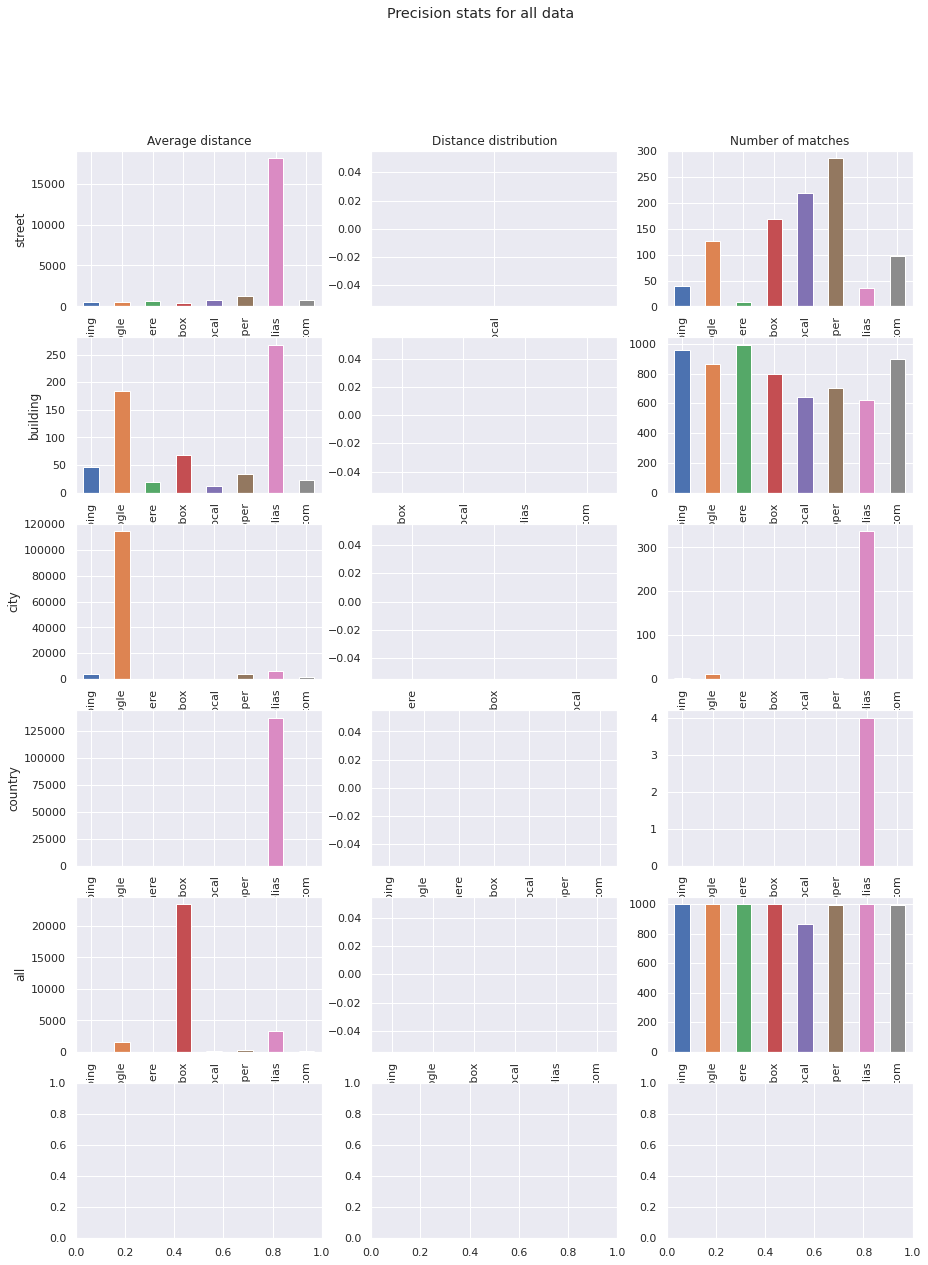

In [318]:
d = show_precision_stats(geocoded_data, "Precision stats for all data")

# img_name=f"{fig_path}/precision_stats_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


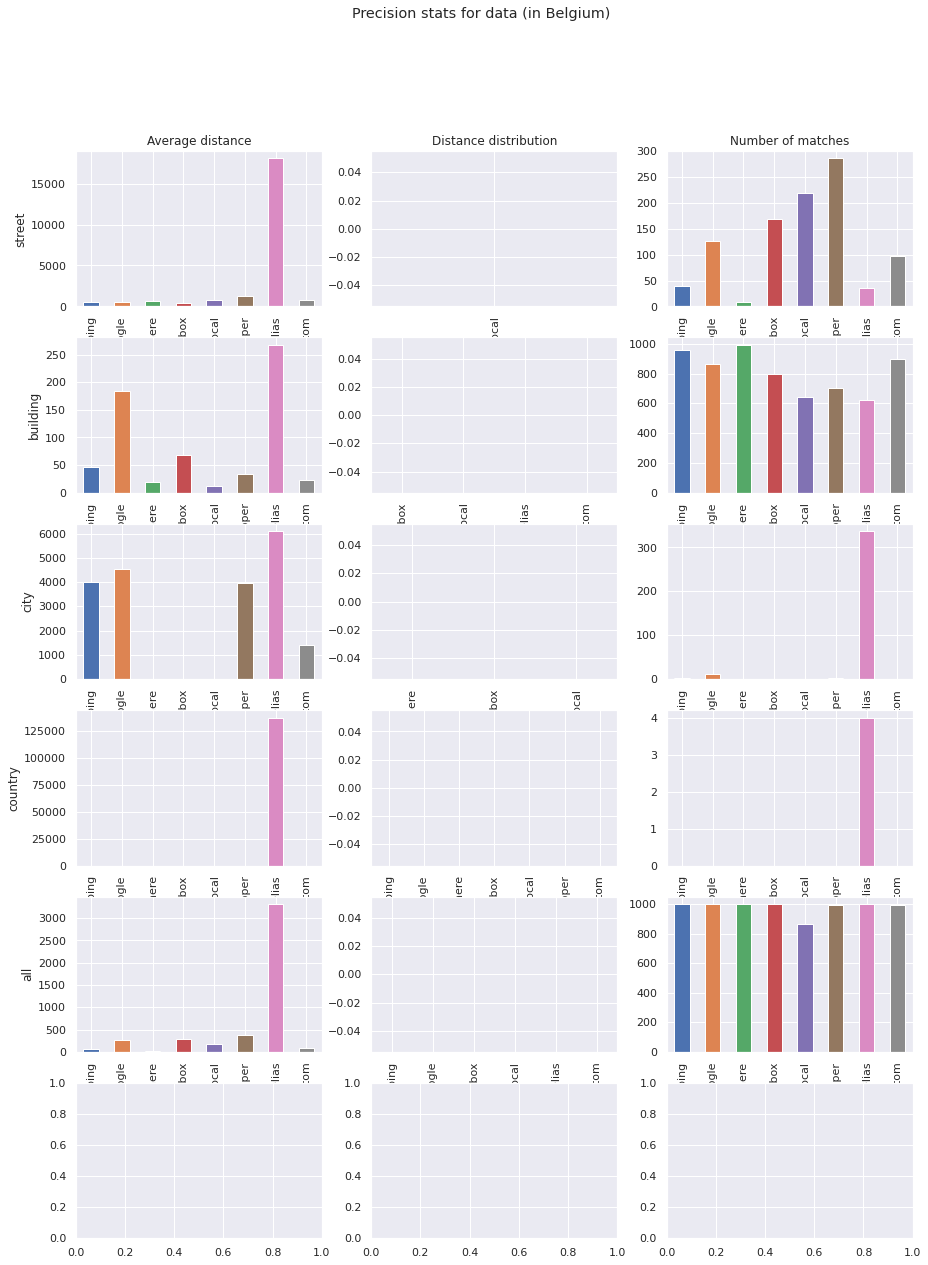

In [319]:
show_precision_stats(geocoded_data[geocoded_data.is_in_belgium], "Precision stats for data (in Belgium)")
pdf.savefig()

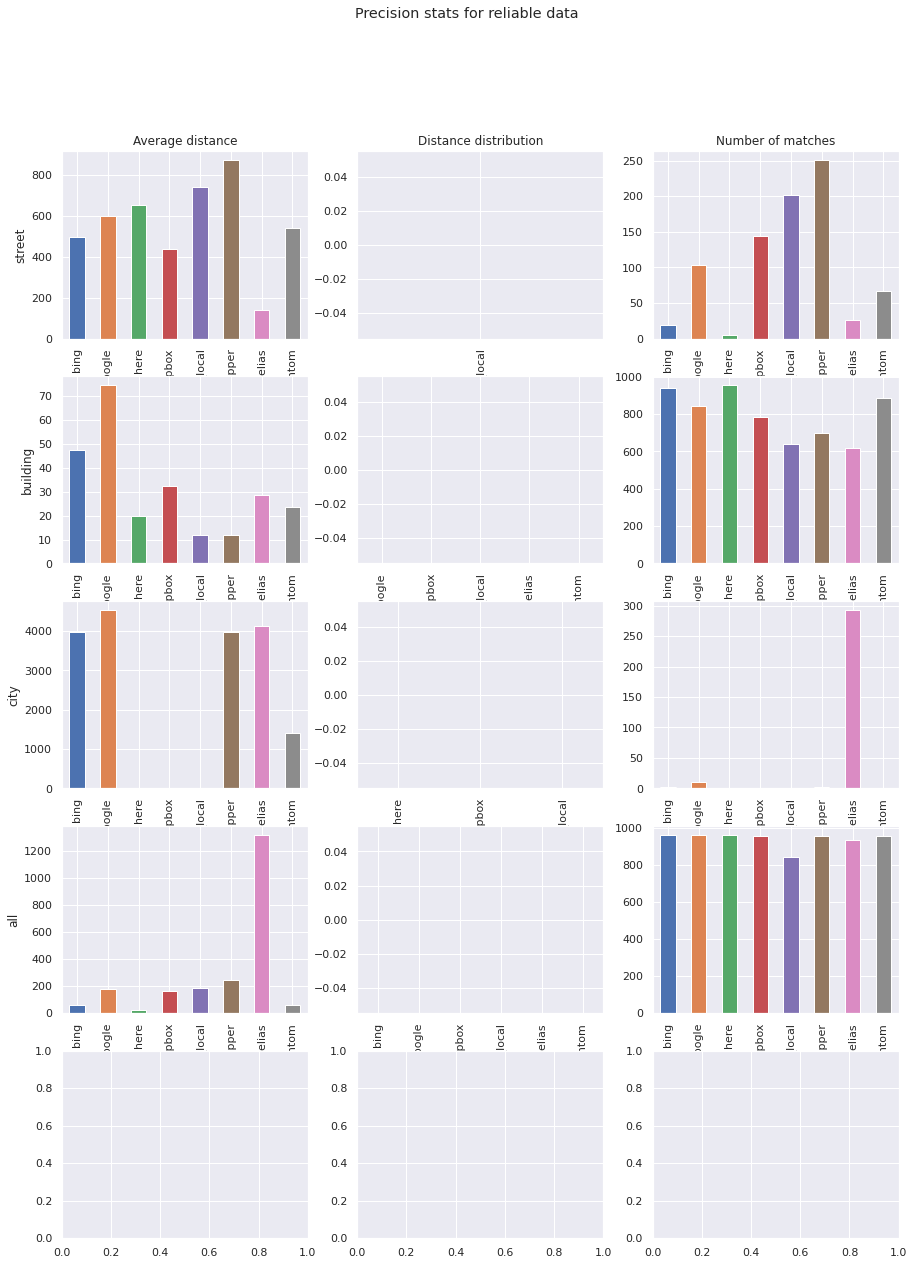

In [320]:
show_precision_stats(geocoded_data[geocoded_data.is_reliable], "Precision stats for reliable data")

# img_name=f"{fig_path}/precision_stats_reliable_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name, orientation='P', width=200)
pdf.savefig()
# plt.show()
# plt.close()


In [321]:
# tics = sorted([10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)])
# pd.cut(geocoded_data.dist_to_median.dropna(), tics, include_lowest=True)

### Distribution

In [322]:
def plot_dist_to_median_distrib(geocoded_data, plotter="px", title=None, filename=None):
    tics = sorted([0] + [10**i for i in range(1, 6)] + [2*10**i for i in range(1, 6)]  +[5*10**i for i in range(1, 6)])
    geocoded_data  = geocoded_data.dropna(subset=["dist_to_median"])
    geocoded_data = geocoded_data.assign(dist_to_median_bins = pd.cut(geocoded_data.dist_to_median, tics, include_lowest=True))
    df = geocoded_data.groupby(["dist_to_median_bins","geocoder"]).address.count().unstack()

    title = 'Distance to median'+(f" ({title})" if title else"")
    if plotter=="plt":

        ax = df.plot(figsize=(15,10), title=title)#.hist()
        ax.set_ylim(0, 100)
        if filename:
            plt.savefig(filename, bbox_inches='tight')

            
    else:
        df = df.reset_index()
        df["x"] = df.dist_to_median_bins.apply(lambda x: x.right)
        fig = px.line(df, x="x", y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        #fig.set_ylim(0, 200)
        fig.show()

    #plt.savefig(f"{fig_path}/dist2med_distrib_{dataset}.png")

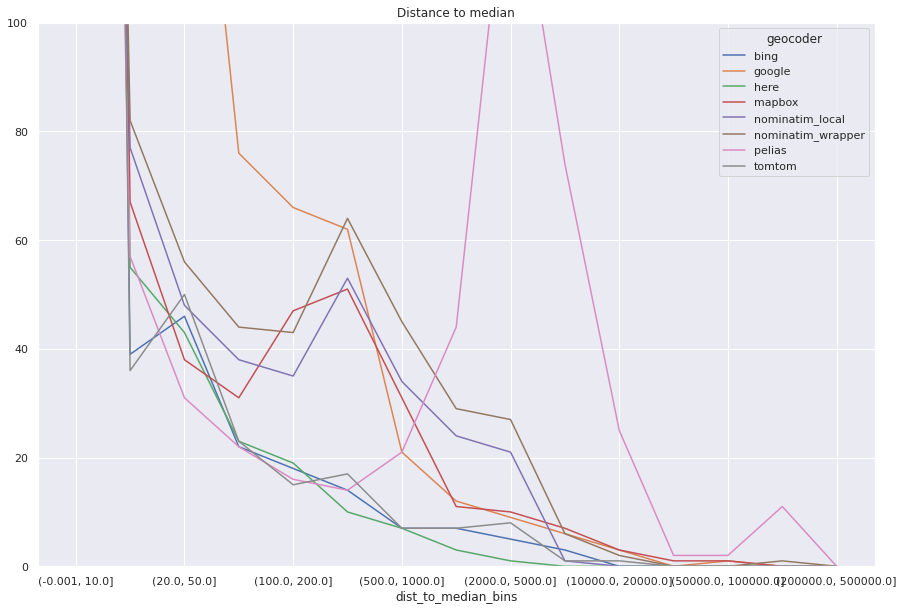

In [323]:
# img_name=f"{fig_path}/dist2med_distrib_{dataset}.png"
img_name=None
plot_dist_to_median_distrib(geocoded_data[geocoded_data.geocoder != "trillium"], "plt", 
                            filename=img_name)

# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()


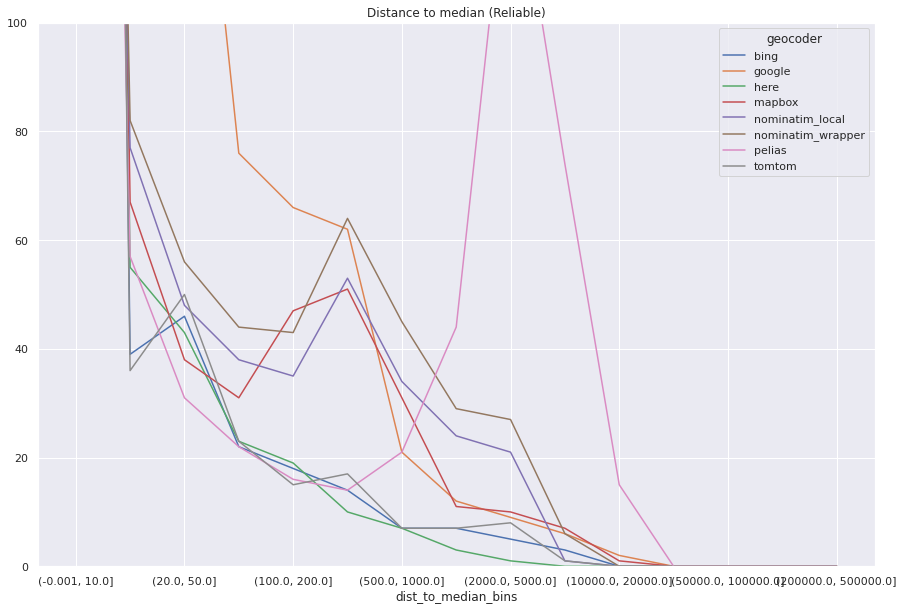

In [324]:
# img_name=f"{fig_path}/dist2med_distrib_reliable_{dataset}.png"

plot_dist_to_median_distrib(geocoded_data[geocoded_data.is_reliable], "plt", 
                            title="Reliable", 
                            filename=img_name)
# pdf_add_image(pdf, img_name)
pdf.savefig()
# plt.show()
# plt.close()



In [325]:
addresses_found_by_NW = geocoded_data[(geocoded_data.geocoder == "nominatim_wrapper") & (geocoded_data.precision == "building")].address
if addresses_found_by_NW.shape[0]>0:
    plot_dist_to_median_distrib(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW) & (geocoded_data.geocoder != "trillium")], 
                            title="for addr. found by NW at build. level")


### Ratio

In [326]:
def plot_threshold_ratio(geocoded_data, plotter="px", title=None, filename=None):
    thresh_ratio = pd.DataFrame()
    for gc in geocoded_data.geocoder.unique():
        g_data = geocoded_data[geocoded_data.geocoder == gc]
        for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
            thresh_ratio = pd.concat([thresh_ratio, pd.DataFrame([{"geocoder": gc, 
                                                "threshold": thresh, 
                                                "ratio": g_data[g_data.dist_to_median <= thresh].shape[0]/g_data.shape[0]}])])
    
    df = thresh_ratio.set_index("threshold").pivot(columns="geocoder", values="ratio")
    
    title = 'Ratio below threshold'+(f" ({title})" if title else"")
    if plotter=="plt":
        df.plot.line(logx=True, figsize=(15,10),  title=title)#x="ratio", y="threshold")
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else :
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title=title, log_x=True)
        fig.show()

    ##return thresh_ratio

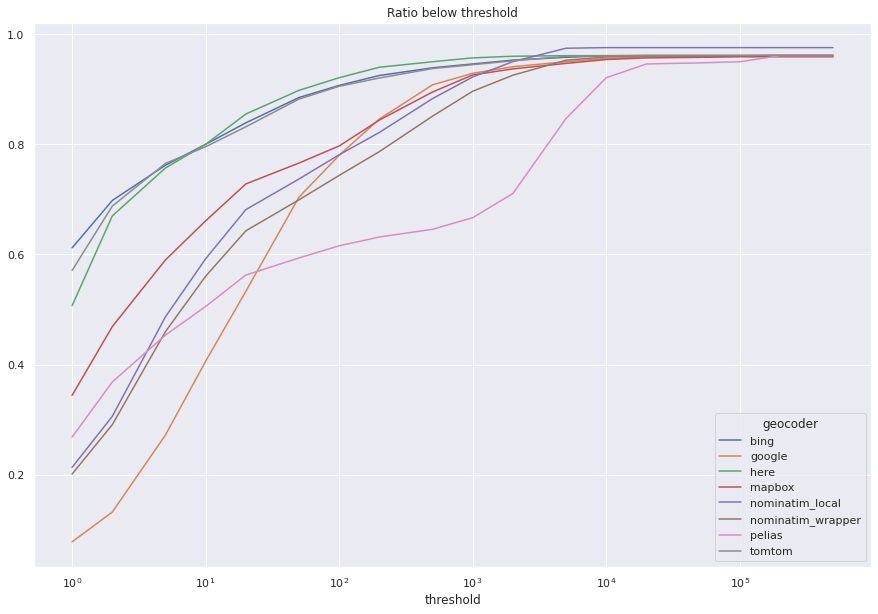

In [327]:
# img_name=f"{fig_path}/dist2med_thresholds_{dataset}.png"

plot_threshold_ratio(geocoded_data, "plt")

pdf.savefig()
# plt.show()
# plt.close()


# pdf_add_image(pdf, img_name)

# plt.savefig(f"{fig_path}/dist2med_thresholds_{dataset}.png")

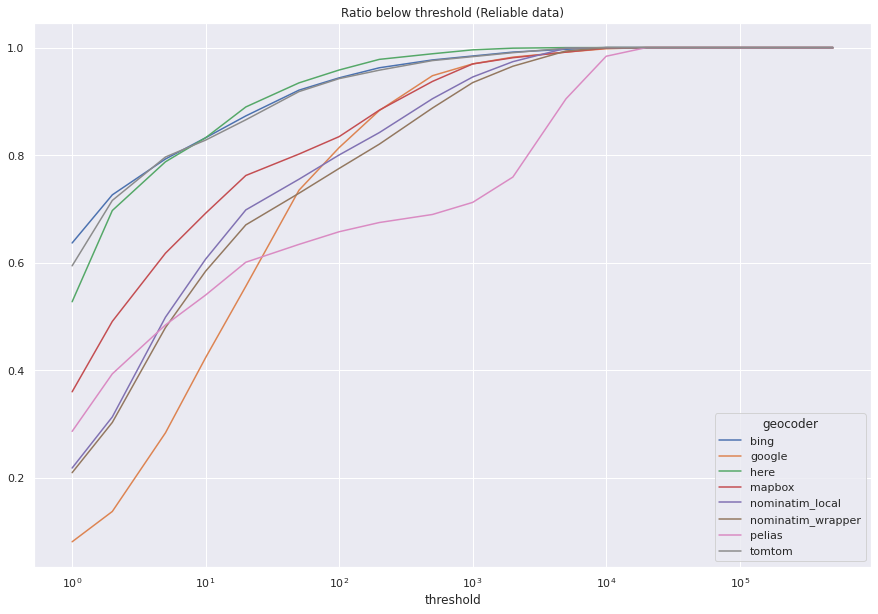

In [328]:
# img_name=f"{fig_path}/dist2med_thresholds_reliable_{dataset}.png"

# plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data", filename=img_name)

# pdf_add_image(pdf, img_name)


plot_threshold_ratio(geocoded_data[geocoded_data.is_reliable], "plt", title="Reliable data")

pdf.savefig()
# plt.show()
# plt.close()



#

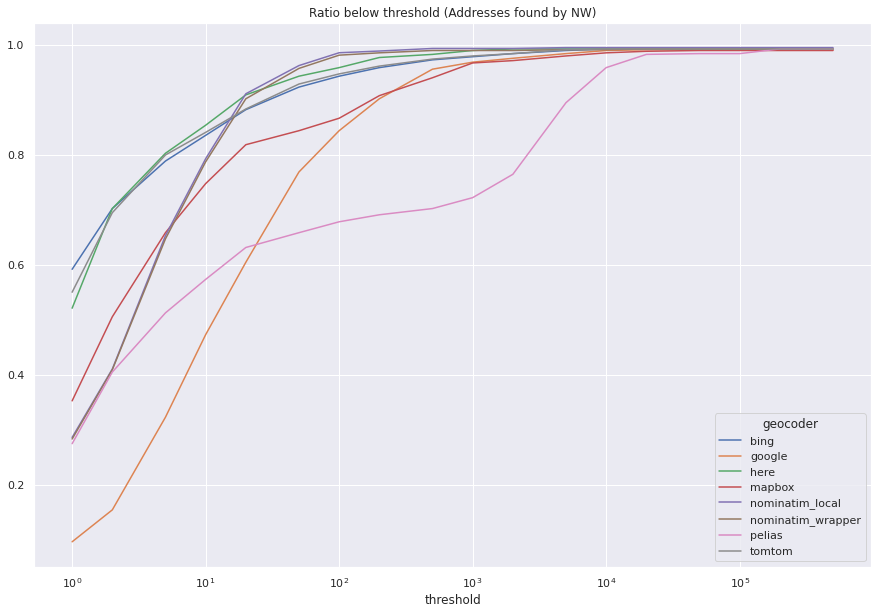

In [329]:
if addresses_found_by_NW.shape[0]>0:
    plot_threshold_ratio(geocoded_data[geocoded_data.address.isin(addresses_found_by_NW)], "plt", title="Addresses found by NW")

## Ratio far from median

In [330]:
def get_far_from_threshold(geocoded_data, plotter="plt", filename=None, title=f"Number of results 'threshold' away from median ({dataset})"):
    far_from_tresh = []
    #for thresh in [10**i for i in range(6)] + [2*10**i for i in range(6)]  +[5*10**i for i in range(6)]:
    for thresh in [10**i for i in range(2, 8)] + [2*10**i for i in range(2, 7)]  +[5*10**i for i in range(2, 7)]:
        d = geocoded_data[geocoded_data.dist_to_median > thresh].geocoder.value_counts().rename("count_far_from_med").reset_index().rename({"index": "geocoder"}, axis=1)
        d["threshold"] = thresh
        far_from_tresh.append(d)
    far_from_tresh = pd.concat(far_from_tresh)#.set_index("index")
    df = far_from_tresh.set_index("threshold").pivot(columns="geocoder", values="count_far_from_med")#.fillna(0)
    #display(df)
    if plotter=="plt":
        df.plot(logx=True, logy=False, figsize=(10,6), title=title)
        if filename:
             plt.savefig(filename, bbox_inches='tight')
    else:
        fig = px.line(df, y=geocoded_data.geocoder.unique(), title="Number of results 'threshold' away from median", log_x=True)
        fig.show()
    

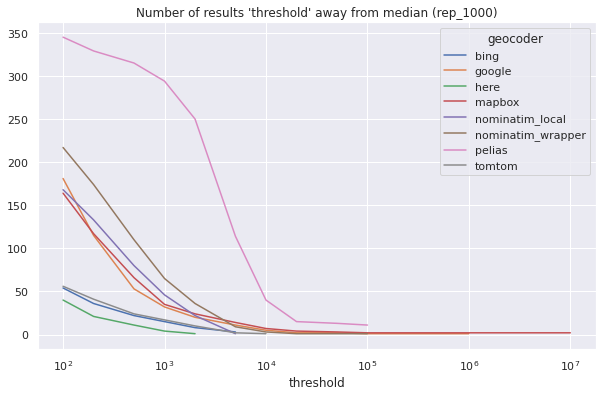

In [331]:
# img_name=f"{fig_path}/far_from_thresholds_{dataset}.png"
get_far_from_threshold(geocoded_data, "plt") #, img_name)

pdf.savefig()
# plt.show()
# plt.close()

# pdf_add_image(pdf, img_name)




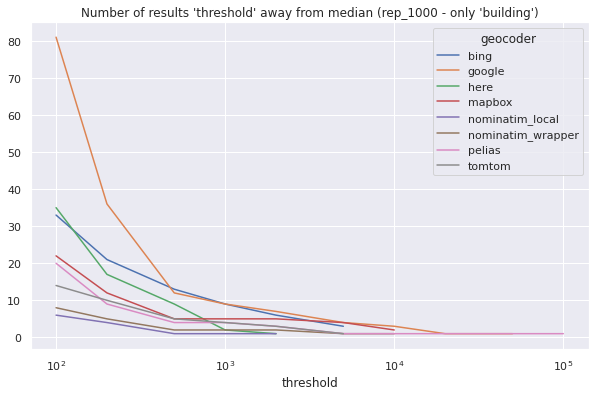

In [332]:
get_far_from_threshold(geocoded_data[(geocoded_data.precision=="building")], 
                       title = f"Number of results 'threshold' away from median ({dataset} - only 'building')")

pdf.savefig()

In [333]:
# geocoded_data[(geocoded_data.precision=="building") & (geocoded_data.geocoder != "trillium")].shape[0]/geocoded_data[(geocoded_data.geocoder != "trillium")].shape[0]